In [1]:
import requests
import os
import zipfile
import sys

import json
import numpy as np
import pickle

from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F

import tqdm
from tqdm import tqdm_notebook
from IPython.display import clear_output

from torch.utils.data import Dataset, DataLoader

from random import choice

import matplotlib.pyplot as plt
from skimage.transform import resize

---vocabulary---

In [2]:
captions_dict = json.load(open('data/captions_tokenized.json'))
captions = list(captions_dict.values())

In [3]:
# Build a Vocabulary

word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        for token in sentence:
          word_counts[token] += 1

In [4]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#'] # before idx=3 (PAD) are special tokens, after idx=3 - real words

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [6]:
class CaptionNet(nn.Module):
    
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, num_layers = 1,
                            hidden_size = lstm_units, batch_first = True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features = lstm_units, out_features=n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        caption_embedding = self.embedding(captions_ix)

        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hn, cn) = self.lstm.forward(caption_embedding, (initial_cell[None], initial_hid[None]))

        # compute logits from lstm_out
        out = self.logits(lstm_out)
        return out

---network---

In [7]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
network = CaptionNet(n_tokens).to(DEVICE)
network.load_state_dict(torch.load('model.pt', map_location=DEVICE))

<All keys matched successfully>

In [10]:
from beheaded_inception3 import beheaded_inception_v3

try:
  if inception is None:
    inception = beheaded_inception_v3().eval()
except NameError:
    inception = beheaded_inception_v3().eval()

def generate_caption(network, image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100, non_random=False):
    if non_random:
        np.random.seed(0)

    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

In [17]:
# sample image
! wget https://s2.best-wallpaper.net/wallpaper/1600x1200/1311/Orange-black-feathers-bird_1600x1200.jpg -O data/img.jpg --no-check-certificate

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2021-05-23 15:34:43--  https://s2.best-wallpaper.net/wallpaper/1600x1200/1311/Orange-black-feathers-bird_1600x1200.jpg
Распознаётся s2.best-wallpaper.net... 148.251.86.66
Устанавливается соединение с s2.best-wallpaper.net|148.251.86.66|:443... соединение установлено.
ПРЕДУПРЕЖДЕНИЕ: невозможно проверить сертификат s2.best-wallpaper.net, запрошенный `/C=US/O=Let's Encrypt/CN=R3':
  Невозможно локально проверить подлинность запрашивающего.
Запрос HTTP послан, ожидается ответ... 200 OK
Длина: 429398 (419K) [image/jpeg]
Сохраняется в каталог: `data/img.jpg'.

     0K .......... .......... .......... .......... .......... 11%  442K 1s
    50K .......... .......... .......... .......... .......... 23%  887K 1s
   100K .......... .......... .......... .......... .......... 35% 11,2M 0s
   150K .......... .......... .......... .......... .......... 47%  911K 0s
   200K .......... .......... ...

a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .


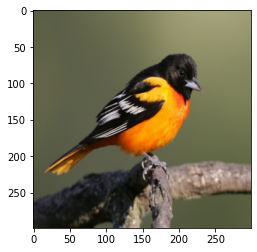

In [11]:
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(network, img, t=5., non_random=True))

In [12]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is a dog'.split()
 
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000
Individual 3-gram: 0.500000
Individual 4-gram: 0.000000


C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [21]:
from nltk.translate.meteor_score import meteor_score
reference = [
    'this is a dog',
    'it is dog',
    'dog it is',
    'a dog, it is' 
]
candidate = 'it is a dog'
 
print('meteor_score' % meteor_score(reference, candidate))

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\Ershov/nltk_data'
    - 'C:\\Anaconda3\\nltk_data'
    - 'C:\\Anaconda3\\share\\nltk_data'
    - 'C:\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Ershov\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [13]:
#inception input image size format
TARGET_SIZE = (299,299)

def generate_image_paths():
    for pic in glob.glob('./Flicker8k_Dataset/*.jpg'):
        yield pic
        
def train_image_names():
    with open('text/Flickr_8k.trainImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
        
def test_image_names():
    with open('text/Flickr_8k.testImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
            
def dev_image_names():
    with open('text/Flickr_8k.devImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
        
def generate_code(image_path_sequence_generator):
    gen = image_path_sequence_generator
    for path in gen:
        file = load_img(path, target_size=TARGET_SIZE)
        data = asarray(file) / 255
        code = generate_code_inception(data)
        code = code.detach() # detach from computational graph
        yield path, code

In [25]:
dev_captions = json.load(open('data/captions_tokenized.json'))

results = []
for path in dev_image_names():
    #print(path)
    img = plt.imread(path)
    img = resize(img, (299, 299))
    
    pic_name = path.split('/')[-1].split('.')[0]
    ref_captions = dev_captions[pic_name]
    ref_captions = [item[1:-1] for item in ref_captions] #drop #START and #END
    caption = generate_caption(network, img, t=5., non_random=True).split()
    print('caption=', caption)
    print('references:')
    for ref in ref_captions:
        print(ref)
    
    print('Individual 1-gram: %f' % sentence_bleu(ref_captions, caption, weights=(1, 0, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 1, 0, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 1, 0, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 0, 1, 0)))
    print('Individual 5-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 0, 0, 1)))
    
    bleu1 = sentence_bleu(ref_captions, caption, weights=(1, 0, 0, 0))
    bleu4 = sentence_bleu(ref_captions, caption) # weights will be (0.25, 0.25, 0.25, 0.25)
    results.append([bleu1, bleu4])

caption= ['a', 'man', 'be', 'sit', 'on', 'a', 'curb', 'in', 'front', 'of', 'a', 'pool', '.']
references:
['the', 'boy', 'lay', 'face', 'down', 'on', 'a', 'skateboard', 'be', 'be', 'push', 'along', 'the', 'ground', 'by', 'another', 'boy', '.']
['two', 'girl', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.']
['two', 'person', 'play', 'on', 'a', 'long', 'skateboard', '.']
['two', 'small', 'child', 'in', 'red', 'shirt', 'play', 'on', 'a', 'skateboard', '.']
['two', 'young', 'child', 'on', 'a', 'skateboard', 'go', 'across', 'a', 'sidewalk']
Individual 1-gram: 0.461538
Individual 2-gram: 0.083333
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'be', 'climb', 'a', 'rock', 'wall', 'with', 'a', 'view', 'of', 'his', 'or', 'her', 'hand', '.']
references:
['a', 'boy', 'in', 'a', 'blue', 'top', 'be', 'jump', 'off', 'some', 'rock', 'in', 'the', 'wood', '.']
['a', 'boy', 'jump', 'off', 'a', 'tan', 'rock', '.']
['a', 'boy', 'jump',

caption= ['a', 'black', 'dog', 'be', 'swim', 'in', 'the', 'water', '.']
references:
['a', 'black', 'dog', 'be', 'shake', 'water', 'off', 'his', 'body', '.']
['a', 'dog', 'on', 'a', 'leash', 'shake', 'while', 'in', 'some', 'water', '.']
['a', 'dog', 'splash', 'in', 'the', 'murky', 'water', '.']
['a', 'dog', 'stand', 'in', 'shallow', 'water', 'on', 'a', 'red', 'leash', '.']
['black', 'dog', 'in', 'the', 'water', 'shake', 'the', 'water', 'off', 'of', 'him', '.']
Individual 1-gram: 0.888889
Individual 2-gram: 0.750000
Individual 3-gram: 0.428571
Individual 4-gram: 0.166667
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'be', 'wear', 'a', 'black', 'jacket', 'and', 'brown', 'dog', '.']
references:
['a', 'boy', 'in', 'a', 'creek', 'throw', 'a', 'rock', '.']
['a', 'boy', 'skip', 'a', 'rock', 'in', 'a', 'creek', '.']
['a', 'boy', 'skip', 'a', 'rock', 'in', 'a', 'stream', '.']
['a', 'boy', 'toss', 'a', 'rock', 'across', 'a', 'river', '.']
['a', 'boy', 'wear', 'jean', ',', 'stand', 'on', 'roc

caption= ['a', 'woman', 'in', 'a', 'red', 'dress', 'and', 'a', 'woman', 'be', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'black', 'haired', 'woman', 'in', 'a', 'white', 'skirt', 'and', 'black', 'boot', 'be', 'carry', 'a', 'red', 'bag', 'and', 'walk', 'down', 'a', 'street', '.']
['a', 'short', 'girl', 'in', 'a', 'white', 'skirt', ',', 'black', 'boot', ',', 'and', 'a', 'gray-green', 'jacket', 'carry', 'a', 'red', 'bag', 'on', 'a', 'sidewalk', '.']
['a', 'woman', 'dress', 'up', 'walk', 'down', 'a', 'sidewalk', 'with', 'her', 'back', 'turn', '.']
['a', 'woman', 'in', 'a', 'skirt', 'and', 'boot', 'with', 'a', 'red', 'bag', 'walk', 'down', 'a', 'sidewalk', '.']
['a', 'woman', 'with', 'a', 'short', ',', 'white', 'skirt', ',', 'black', 'boot', 'and', 'a', 'red', 'bag', 'walk', 'away', '.']
Individual 1-gram: 0.873140
Individual 2-gram: 0.601397
Individual 3-gram: 0.359810
Individual 4-gram: 0.233877
Individual 5-gram: 0.085046
caption= ['a', 'black', 'dog', 'run', 'on', 'the', 'gras

caption= ['a', 'child', 'in', 'a', 'red', 'jacket', 'and', 'goggles', 'jump', 'into', 'a', 'pool', 'of', 'snow', '.']
references:
['a', 'man', 'wear', 'a', 'green', 'jacket', 'and', 'hat', 'be', 'snowboard', '.']
['a', 'person', 'in', 'a', 'green', 'coat', 'be', 'snowboard', '.']
['a', 'snowboarder', 'in', 'a', 'green', 'jacket', 'catch', 'some', 'air', '.']
['a', 'snowboarder', 'jump', 'off', 'of', 'a', 'jump', '.']
['a', 'snowboarder', 'jump', 'on', 'the', 'snow', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.214286
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'young', 'boy', 'with', 'a', '#UNK#', 'pop', 'and', 'a', 'child', 'play', 'a', 'game', '.']
references:
['a', 'boy', 'and', 'a', 'baby', 'in', 'a', 'ridable', 'truck', '.']
['two', 'child', 'ride', 'in', 'a', 'small', 'child', "'s", 'toy', 'vehicle', '.']
['two', 'little', 'boy', 'be', 'drive', 'past', 'adult', 'in', 'their', 'toy', 'jeep', '.']
['two', 'little', 'bo

caption= ['a', 'black', 'dog', 'run', 'through', 'a', 'field', '.']
references:
['a', 'brown', 'dog', 'be', 'carry', 'a', 'stick', 'in', 'its', 'mouth', '.']
['a', 'brown', 'dog', 'be', 'fetch', 'a', 'stick', 'in', 'a', 'country', 'set', '.']
['a', 'dog', 'be', 'stand', 'in', 'a', 'fenced', 'in', 'field', 'with', 'a', 'stick', 'in', 'his', 'mouth', '.']
['a', 'dog', 'run', 'through', 'a', 'field', 'with', 'a', 'stick', 'in', 'his', 'mouth', '.']
['a', 'brown', 'dog', 'be', 'bring', 'back', 'a', 'stick', 'on', 'green', 'grass', '.']
Individual 1-gram: 0.601378
Individual 2-gram: 0.392737
Individual 3-gram: 0.343645
Individual 4-gram: 0.274916
Individual 5-gram: 0.171822
caption= ['a', 'boy', 'wear', 'a', 'blue', 'shirt', 'be', 'stand', 'with', 'a', 'camera', 'up', 'in', 'the', 'background', '.']
references:
['a', 'lady', 'look', 'surprise', '.']
['an', 'asian', 'girl', 'look', 'surprise', 'in', 'front', 'of', 'a', 'brick', 'window']
['an', 'asian', 'girl', 'make', 'a', 'surprised', 'fac

caption= ['a', 'person', 'on', 'a', 'snowboard', 'jump', 'off', 'a', 'ramp', '.']
references:
['a', 'boy', 'on', 'his', 'bike', 'be', 'wear', 'a', 'blue', 'shirt', 'and', 'be', 'in', 'midair', '.']
['a', 'cyclist', 'be', 'perform', 'a', 'jump', 'stunt', 'in', 'a', 'skate', 'and', 'cycle', 'park', '.']
['an', 'angle', 'picture', 'of', 'a', 'person', 'do', 'a', 'trick', 'on', 'a', 'bike', '.']
['a', 'person', 'on', 'a', 'bmx', 'bike', ',', 'run', 'a', 'course', '.']
['young', 'man', 'do', 'stunt', 'on', 'bicycle', 'near', 'beach', '.']
Individual 1-gram: 0.700000
Individual 2-gram: 0.333333
Individual 3-gram: 0.250000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'suit', 'and', 'a', 'woman', 'be', 'hold', 'a', 'camera', '.']
references:
['a', 'man', 'in', 'a', 'gray', 'shirt', 'be', 'stand', 'in', 'a', 'crowded', 'street', 'at', 'night', '.']
['a', 'man', 'stand', 'in', 'a', 'crowd', 'hold', 'a', 'white', 'object', '.']
['a', 'man', 'with', 'gla

caption= ['a', 'man', 'be', 'stand', 'on', 'a', 'dock', 'at', 'a', 'beach', '.']
references:
['a', 'group', 'of', 'person', 'wait', 'to', 'ride', 'boat', '.']
['four', 'ferry', 'boat', 'be', 'dock', 'at', 'a', 'visitor', "'s", 'center', 'with', 'passenger', 'wait', 'to', 'board', '.']
['people', 'be', 'gather', 'on', 'a', 'platform', 'in', 'water', 'for', 'a', 'ceremony', '.']
['people', 'congregate', 'on', 'a', 'platform', 'in', 'a', 'river', 'among', 'decorate', 'boat', '.']
['people', 'wait', 'to', 'board', 'boat', '.']
Individual 1-gram: 0.581064
Individual 2-gram: 0.273930
Individual 3-gram: 0.101456
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'soccer', 'player', 'in', 'a', 'red', 'shirt', 'and', 'black', 'short', 'play', 'soccer', '.']
references:
['a', 'boy', 'hit', 'a', 'soccer', 'ball', 'with', 'his', 'chest', '.']
['a', 'child', 'be', 'hit', 'a', 'soccer', 'ball', 'with', 'their', 'chest', '.']
['a', 'child', 'be', 'play', 'soccer', 'with', 'a', 'bl

caption= ['three', 'dog', 'play', 'in', 'the', 'snow', '.']
references:
['three', 'dog', 'be', 'run', 'down', 'a', 'snow', 'cover', 'hill', '.']
['three', 'dog', 'race', 'in', 'the', 'snow', 'together', '.']
['three', 'dog', 'run', 'through', 'the', 'snow', '.']
['three', 'dog', 'walk', 'together', 'across', 'a', 'snowy', 'field', '.']
['two', 'mostly', 'white', 'dog', 'be', 'in', 'the', 'snow', 'with', 'a', 'black', 'and', 'red', 'dog', '.']
Individual 1-gram: 0.857143
Individual 2-gram: 0.666667
Individual 3-gram: 0.400000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['two', 'girl', 'in', 'bikini', 'walk', 'along', 'a', 'beach', '.']
references:
['three', 'person', 'be', 'squat', 'by', 'the', 'water', '.']
['three', 'child', 'bend', 'over', 'to', 'look', 'at', 'the', 'water', 'edge', 'at', 'a', 'lake', '.']
['three', 'kid', 'lean', 'into', 'the', 'water', 'edge', 'wear', 'bright', 'pants', '.']
['three', 'kid', 'squat', 'down', 'and', 'look', 'at', 'the', 'ground'

caption= ['a', 'dog', 'run', 'through', 'a', 'field', 'of', 'flower', '.']
references:
['two', 'adult', 'walk', 'in', 'a', 'street', 'in', 'a', 'suburban', 'area']
['two', 'distant', 'boy', 'walk', 'down', 'snowy', 'street', 'in', 'urban', 'area', '.']
['two', 'person', 'walk', 'across', 'a', 'street', '.']
['two', 'person', 'walk', 'on', 'a', 'street', 'with', 'barren', 'tree', '.']
['two', 'person', 'walk', 'on', 'a', 'street', 'with', 'lot', 'of', 'bare', 'tree', 'around', 'and', 'snow', 'on', 'the', 'ground', '.']
Individual 1-gram: 0.397706
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'boy', 'in', 'a', 'white', 'shirt', 'and', 'jean', 'short', 'be', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'boy', 'bounce', 'on', 'a', 'trampoline', '.']
['a', 'boy', 'jump', 'on', 'a', 'trampoline', '.']
['a', 'boy', 'jump', 'on', 'a', 'trampoline', '.']
['a', 'little', 'boy', 'in', 'a', 'white', 'long', '

caption= ['a', 'woman', 'stand', 'in', 'a', 'river', '.']
references:
['a', 'child', 'and', 'a', 'woman', 'be', 'at', 'water', 'edge', 'in', 'a', 'big', 'city', '.']
['a', 'large', 'lake', 'with', 'a', 'lone', 'duck', 'swim', 'in', 'it', 'with', 'several', 'person', 'around', 'the', 'edge', 'of', 'it', '.']
['a', 'little', 'boy', 'at', 'a', 'lake', 'watch', 'a', 'duck', '.']
['a', 'young', 'boy', 'wave', 'his', 'hand', 'at', 'a', 'duck', 'in', 'the', 'water', 'surround', 'by', 'a', 'green', 'park', '.']
['two', 'person', 'be', 'at', 'the', 'edge', 'of', 'a', 'lake', ',', 'face', 'the', 'water', 'and', 'a', 'city', 'skyline', '.']
Individual 1-gram: 0.465314
Individual 2-gram: 0.217146
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'person', 'on', 'ski', "'s", 'ski', 'be', 'stand', 'on', 'a', 'snowy', 'mountain', '.']
references:
['a', 'winter', 'landscape', 'with', 'four', 'person', 'walk', 'in', 'the', 'snow', '.']
['beautiful', 'sno

caption= ['a', 'group', 'of', 'person', 'be', 'stand', 'in', 'front', 'of', 'a', 'statue', 'of', 'a', 'house', '.']
references:
['a', 'group', 'of', 'person', 'sit', 'on', 'a', 'sidewalk', '.']
['girl', 'sit', 'on', 'bench', '.']
['a', 'girl', 'be', 'wear', 'silver', 'shoe', 'and', 'a', 'pink', 'jacket', '.']
['girl', 'take', 'a', 'break', 'in', 'the', 'afternoon', '.']
['two', 'teenage', 'girl', 'be', 'texting', 'in', 'a', 'park', '.']
Individual 1-gram: 0.533333
Individual 2-gram: 0.214286
Individual 3-gram: 0.153846
Individual 4-gram: 0.083333
Individual 5-gram: 0.000000
caption= ['a', 'boy', 'in', 'a', 'red', 'shirt', 'and', 'jean', 'short', 'be', 'run', 'on', 'a', 'sidewalk', '.']
references:
['a', 'child', 'in', 'denim', 'play', 'hopscotch', '.']
['closeup', 'of', 'a', 'pair', 'of', 'feet', 'in', 'mid', 'jump', 'while', 'play', 'hopscotch', '.']
['someone', 'be', 'play', 'hopscotch', 'on', 'a', 'chalk', 'out', 'grid', 'on', 'the', 'ground', '.']
['a', 'kid', 'be', 'play', 'hopsco

caption= ['a', 'little', 'boy', 'be', 'play', 'with', 'a', 'toy', 'on', 'a', 'hardwood', 'floor', '.']
references:
['a', 'child', 'attempt', 'to', 'enter', 'a', 'house', 'through', 'the', 'doggy', 'door', '.']
['a', 'child', "'s", 'leg', 'while', 'squeeze', 'through', 'a', 'dog', 'door', '.']
['a', 'child', 'wear', 'gray', 'short', 'and', 'pink-bottomed', 'sneaker', 'crawl', 'through', 'a', 'window', '.']
['a', 'child', 'wear', 'pink', 'soled', 'sneaker', 'be', 'climb', 'headfirst', 'through', 'a', 'window', '.']
['a', 'kid', 'climb', 'through', 'a', 'small', 'door', '.']
Individual 1-gram: 0.307692
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'brown', 'and', 'white', 'dog', 'run', 'through', 'the', 'snow', '.']
references:
['a', 'brown', 'and', 'white', 'dog', 'run', 'into', 'the', 'water']
['a', 'brown', 'and', 'white', 'dog', 'run', 'through', 'water', 'towards', 'a', 'toy', '.']
['a', 'brown', 'dog', 

caption= ['a', 'group', 'of', 'person', 'sit', 'in', 'a', 'park', 'bench', '.']
references:
['child', 'in', 'a', 'scene', 'be', 'in', 'a', 'pet', 'zoo', 'and', 'be', 'act', 'like', 'a', 'duck', 'or', 'chicken', '.']
['two', 'child', 'play', 'in', 'a', 'yard', 'with', 'farm', 'animal', '.']
['two', 'child', 'play', 'around', 'farm', 'animal', '.']
['two', 'child', 'play', 'in', 'a', 'fenced', 'in', 'grassy', 'area', 'with', 'farm', 'animal', '.']
['two', 'kid', 'play', 'in', 'a', 'yard', 'with', 'some', 'farm', 'animal', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.111111
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'blue', 'shirt', 'be', 'hold', 'a', 'baby', 'with', 'a', '#UNK#', '.']
references:
['a', 'lady', 'hold', 'a', 'baby', 'and', 'they', 'both', 'be', 'look', 'at', 'one', 'another', '.']
['a', 'lady', 'with', 'glasses', 'hold', 'a', 'baby', 'who', 'be', 'look', 'up', 'at', 'her', '.']
['a', 'woman'

caption= ['a', 'person', 'on', 'a', 'bike', 'be', 'ride', 'through', 'the', 'air', 'while', 'a', 'crowd', 'watch', '.']
references:
['child', 'on', 'tricycle', '.']
['child', 'ride', 'tricycle', 'on', 'the', 'pavement', '.']
['little', 'kid', 'be', 'line', 'up', 'to', 'race', 'in', 'a', 'tricycle', 'race', '.']
['two', 'child', 'ride', 'tricycle', 'in', 'a', 'race', '.']
['two', 'child', 'ride', 'tricycle', 'be', 'pass', 'a', 'pink', 'banner', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'and', 'white', 'dog', 'be', 'run', 'with', 'a', 'black', 'and', 'white', 'dog', 'on', 'a', 'beach', '.']
references:
['three', 'dog', 'be', 'play', 'together', 'in', 'the', 'dirt', '.']
['three', 'dog', 'of', 'vary', 'size', 'and', 'color', 'stand', 'on', 'dirt', '.']
['three', 'dog', 'run', 'in', 'the', 'dirt', '.']
['three', 'dog', 'run', 'together', '.']
['three', 'dog', 'who'

caption= ['a', 'man', 'in', 'a', '#UNK#', 'shirt', 'be', 'hold', 'a', '#UNK#', '.']
references:
['a', 'woman', 'have', 'a', 'finger', 'point', 'in', 'her', 'face', '.']
['a', 'woman', 'sit', 'at', 'a', 'table', 'near', 'a', 'window', ',', 'with', 'a', 'plate', 'and', 'glass', 'in', 'front', 'of', 'her', '.']
['a', 'woman', 'sit', 'down', 'to', 'have', 'a', 'meal', 'be', 'be', 'point', 'at', '.']
['a', 'woman', 'wear', 'a', 'floral', 'dress', 'sit', 'as', 'a', 'finger', 'be', 'point', 'at', 'her', '.']
['on', 'the', 'left', ',', 'a', 'hand', 'point', 'to', 'a', 'surprised', 'look', 'woman', 'with', 'short', 'hair', 'sit', 'at', 'a', 'table', 'in', 'front', 'of', 'a', 'window']
Individual 1-gram: 0.545455
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'young', 'girl', 'with', 'a', 'pink', 'shirt', 'and', 'blue', 'eye', 'be', 'on', 'a', 'red', 'and', 'blue', 'baseball', '.']
references:
['a', 'football', 'team

caption= ['a', 'black', 'dog', 'be', 'run', 'through', 'a', 'field', '.']
references:
['a', 'black', 'dog', 'stand', 'in', 'some', 'grass', 'hold', 'a', 'white', 'plastic', 'item', 'in', 'its', 'mouth', '.']
['a', 'black', 'dog', 'be', 'carry', 'a', 'white', 'dog', 'toy', 'through', 'a', 'field', 'of', 'high', 'grass', '.']
['a', 'black', 'dog', 'be', 'hold', 'a', 'white', 'object', 'in', 'its', 'teeth', '.']
['a', 'black', 'dog', 'with', 'a', 'white', 'toy', 'in', 'his', 'mouth', 'in', 'a', 'field', 'of', 'grass', '.']
['a', 'black', 'labrador', 'retriever', 'in', 'a', 'grassy', 'field', 'return', 'with', 'a', 'white', 'nubby', 'cylinder', 'in', 'its', 'mouth', '.']
Individual 1-gram: 0.636917
Individual 2-gram: 0.447832
Individual 3-gram: 0.307085
Individual 4-gram: 0.119422
Individual 5-gram: 0.000000
caption= ['a', 'person', 'on', 'a', 'bike', 'be', 'jump', 'over', 'a', 'hill', '.']
references:
['a', 'guy', 'in', 'a', 'yellow', 'shirt', 'with', 'a', 'bike', 'get', 'very', 'high', '

caption= ['a', 'young', 'girl', 'wear', 'a', 'pink', 'hat', 'sit', 'on', 'a', 'beach', '.']
references:
['a', 'little', 'girl', 'bury', 'in', 'the', 'sand', '.']
['a', 'little', 'girls', 'waist', 'high', 'in', 'sand']
['a', 'little', 'girl', 'with', 'a', 'hat', 'sit', 'between', 'a', 'woman', "'s", 'feet', 'in', 'the', 'sand', 'in', 'front', 'of', 'a', 'pair', 'of', 'colorful', 'tent', '.']
['a', 'little', 'girl', 'in', 'a', 'yellow', 'hat', 'be', 'bury', 'up', 'to', 'her', 'waist', 'in', 'the', 'sand', 'on', 'a', 'beach', '.']
['a', 'small', 'baby', 'in', 'a', 'yellow', 'have', 'the', 'lower', 'half', 'of', 'her', 'body', 'bury', 'in', 'sand', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.363636
Individual 3-gram: 0.200000
Individual 4-gram: 0.111111
Individual 5-gram: 0.000000
caption= ['a', 'football', 'player', 'in', 'a', 'red', 'uniform', 'be', 'tackle', 'a', 'player', 'in', 'a', 'red', 'and', 'white', 'uniform', '.']
references:
['a', 'goal', 'defend', 'the', 'goal', 'in'

caption= ['a', 'man', 'on', 'a', 'motorcycle', 'perform', 'a', 'wheelie', 'on', 'a', 'track', '.']
references:
['a', 'man', 'in', 'a', 'black', 'and', 'red', 'jacket', 'and', 'helmet', 'do', 'a', 'stunt', 'on', 'a', 'motorbike', '.']
['a', 'man', 'stand', 'on', 'a', 'motorcycle', 'do', 'a', 'stunt']
['a', 'person', 'perform', 'a', 'wheelie', 'trick', 'on', 'a', 'motorcycle', 'in', 'a', 'park', 'lot', '.']
['motorcycle', 'daredevil', 'on', 'reared', 'motorcycle', '.']
['someone', 'ride', 'sideways', 'on', 'a', 'motorcycle', '.']
Individual 1-gram: 0.705401
Individual 2-gram: 0.384764
Individual 3-gram: 0.169296
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'on', 'a', 'bicycle', 'be', 'do', 'a', 'trick', '.']
references:
['a', 'boy', 'perform', 'a', 'stunt', 'on', 'a', 'bmx', 'bike', '.']
['a', 'man', 'do', 'a', 'bicycle', 'trick', 'on', 'a', 'concrete', 'obstacle', '.']
['a', 'man', 'do', 'trick', 'on', 'a', 'bmx', 'bike']
['an', 'extreme', 'bicyclist', '

caption= ['a', 'baby', 'in', 'a', 'blue', 'shirt', 'be', 'hold', 'a', 'baby', 'in', 'her', 'hand', '.']
references:
['a', 'blond', 'toddler', 'wear', 'a', 'blue', 'sweater', ',', 'ride', 'on', 'a', 'wooden', 'toy', '.']
['a', 'child', 'in', 'blue', 'and', 'yellow', 'clothing', 'be', 'cling', 'to', 'playground', 'equipment', 'with', 'an', 'adult', 'nearby', '.']
['a', 'little', 'boy', 'be', 'play', 'on', 'a', 'playground', 'rock', 'toy', '.']
['a', 'toddler', 'with', 'a', 'look', 'of', 'fear', 'on', 'his', 'face', 'be', 'on', 'playground', 'equipment', '.']
['boy', 'in', 'a', 'blue', 'shirt', 'ride', 'on', 'a', 'toy', '.']
Individual 1-gram: 0.571429
Individual 2-gram: 0.230769
Individual 3-gram: 0.166667
Individual 4-gram: 0.090909
Individual 5-gram: 0.000000
caption= ['a', 'baby', 'sit', 'in', 'a', 'chair', 'with', 'a', 'paper', 'room', 'and', 'smile', '.']
references:
['a', 'boy', 'in', 'a', 'robe', 'sit', 'in', 'a', 'chair', '.']
['a', 'little', 'dark-haired', 'boy', 'on', 'a', 'cha

caption= ['two', 'dog', 'play', 'together', '.']
references:
['a', 'brown', 'and', 'black', 'dog', 'and', 'a', 'white', 'dog', 'be', 'wrestle', 'on', 'a', 'carpet', '.']
['a', 'large', 'white', 'dog', 'and', 'a', 'small', 'brown', 'dog', 'fight', '.']
['a', 'white', 'dog', 'open', 'its', 'mouth', 'near', 'a', 'small', 'dog', '.']
['a', 'white', 'dog', 'play', 'with', 'a', 'brown', 'dog', 'on', 'carpet', '.']
['two', 'dog', 'play', 'rough', '.']
Individual 1-gram: 0.800000
Individual 2-gram: 0.500000
Individual 3-gram: 0.333333
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'person', 'be', 'ski', 'down', 'a', 'snowy', 'hill', '.']
references:
['a', 'person', 'ski', 'down', 'a', 'very', 'large', 'snow', 'cover', 'mountain', '.']
['a', 'skier', 'be', 'go', 'down', 'a', 'huge', 'snow', 'cover', 'slope', '.']
['a', 'skier', 'ski', 'down', 'a', 'large', 'mountain']
['a', 'man', 'be', 'ski', 'down', 'a', 'steep', ',', 'snowy', 'white', 'mountain', 'with', 'cloud', 'in'

caption= ['a', 'boy', 'and', 'a', 'boy', 'be', 'kiss', 'a', 'girl', 'in', 'a', 'black', 'shirt', 'run', '.']
references:
['a', 'boy', 'and', 'a', 'toddler', 'boy', 'stand', 'by', 'a', 'water', 'fountain', '.']
['two', 'boy', 'in', 'bright', 'blue', 'jean', 'stand', 'at', 'a', 'water', 'fountain', '.']
['two', 'boy', 'sand', 'next', 'to', 'a', 'drink', 'fountain', 'in', 'a', 'park', '.']
['two', 'child', 'stand', 'near', 'a', 'water', 'fountain', '.']
['two', 'little', 'boy', 'at', 'a', 'water', 'fountain', '.']
Individual 1-gram: 0.533333
Individual 2-gram: 0.285714
Individual 3-gram: 0.153846
Individual 4-gram: 0.083333
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'be', 'stand', 'on', 'a', 'rock', 'overlook', 'the', 'water', '.']
references:
['a', 'man', 'take', 'a', 'picture', 'of', 'a', 'woman', 'in', 'a', 'blue', 'top', 'and', 'jean', 'stand', 'on', 'a', 'stump', 'near', 'the', 'water', '.']
['a', 'woman', 'balance', 'on', 'a', 'stump', 'while', 'a', 'man', 'take', 'her', 'pi

caption= ['three', 'child', 'be', 'walk', 'on', 'a', 'street', '.']
references:
['a', 'group', 'of', 'friend', 'play', 'instrument', 'in', 'the', 'middle', 'of', 'the', 'wood', '.']
['a', 'group', 'of', 'person', 'be', 'in', 'the', 'wood', 'play', 'instrument', '.']
['a', 'group', 'of', 'person', 'play', 'instrument', 'in', 'the', 'wood', '.']
['a', 'group', 'of', 'six', 'man', 'stand', 'in', 'a', 'circle', 'play', 'instrument', 'in', 'a', 'wooded', 'park', 'lot', '.']
['six', 'man', 'have', 'a', 'band', 'practice', 'in', 'the', 'wood', '.']
Individual 1-gram: 0.292050
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'hat', 'and', 'a', 'brown', 'coat', 'be', 'sit', 'on', 'a', 'bench', '.']
references:
['a', 'baby', 'boy', 'cry', 'while', 'sit', 'in', 'the', 'grass', 'at', 'a', 'park', '.']
['a', 'boy', 'cry', 'in', 'the', 'grass', '.']
['a', 'little', 'boy', 'cry', 'on', 'the', 'grass

caption= ['a', 'little', 'girl', 'in', 'a', 'pink', 'bathe', 'suit', 'be', 'sit', 'on', 'a', 'bed', '.']
references:
['a', 'boy', 'in', 'blue', 'short', 'slide', 'down', 'a', 'slide', 'into', 'a', 'pool', '.']
['a', 'boy', 'in', 'blue', 'swim', 'trunk', 'slide', 'down', 'a', 'yellow', 'slide', 'into', 'a', 'wade', 'pool', 'with', 'inflatable', 'toy', 'float', 'in', 'the', 'water', '.']
['a', 'boy', 'ride', 'down', 'a', 'slide', 'into', 'a', 'small', 'backyard', 'pool', '.']
['a', 'boy', 'slide', 'down', 'a', 'slide', 'into', 'a', 'pool', 'with', 'colorful', 'tube', '.']
['a', 'child', 'be', 'fall', 'off', 'a', 'slide', 'onto', 'color', 'balloon', 'float', 'on', 'a', 'pool', 'of', 'water', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.076923
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'child', 'be', 'play', 'with', 'a', 'soccer', 'ball', '.']
references:
['a', 'boy', 'chase', 'a', 'yellow', 'ball', '.']
['a', 'child', 'in', 

caption= ['a', 'young', 'girl', 'slide', 'down', 'a', 'slide', '.']
references:
['a', 'child', 'do', 'a', 'karate', 'kick', 'and', 'jump', 'from', 'a', 'red', 'couch', '.']
['a', 'child', 'be', 'perform', 'a', 'jump', 'kick', 'pose', 'in', 'midair', 'over', 'a', 'red', 'couch', '.']
['little', 'boy', 'do', 'a', 'fly', 'kick', 'in', 'a', 'lited', 'room', 'with', 'shadow', '.']
['a', 'boy', 'be', 'bounce', 'on', 'a', 'red', 'couch', '.']
['the', 'boy', 'leap', 'of', 'his', 'bed', 'with', 'a', 'karate', 'kick', '.']
Individual 1-gram: 0.330936
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'young', 'boy', 'jump', 'off', 'a', 'swing', '.']
references:
['a', 'girl', 'wear', 'pink', 'swing', 'on', 'a', 'swing', '.']
['a', 'little', 'girl', 'be', 'swing', 'high', 'above', 'a', 'wooden', 'fence', 'on', 'a', 'swing', '.']
['a', 'young', 'girl', 'in', 'a', 'pick', 'shirt', 'swing', 'up', 'in', 'the', 'air', 'on', 'a'

caption= ['a', 'young', 'girl', 'in', 'a', 'swim', 'pool', '.']
references:
['a', 'boy', 'with', 'his', 'mouth', 'wide', 'open', 'dress', 'in', 'a', 'yellow', 'life', 'jacket', 'and', 'goggles', 'in', 'water', 'with', 'a', 'man', 'next', 'to', 'him', '.']
['a', 'father', 'and', 'child', 'enjoy', 'the', 'water', '.']
['a', 'man', 'and', 'child', 'wear', 'a', 'yellow', 'life', 'vest', 'look', 'up', 'from', 'the', 'water', '.']
['an', 'open', 'mouth', 'child', 'in', 'goggles', 'and', 'a', 'yellow', 'life', 'vest', 'pose', 'with', 'a', 'smile', 'man', '.']
['man', 'and', 'boy', 'wear', 'life', 'jacket', 'in', 'water', 'pose', 'for', 'a', 'picture']
Individual 1-gram: 0.500000
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'hold', 'a', 'sign', 'with', 'a', '#UNK#', '.']
references:
['a', 'man', 'in', 'sunglasses', 'and', 'a', 'hat', 'be', 'see', 'among', 'a', 'crowd', '.']

caption= ['a', 'boy', 'be', 'run', 'on', 'a', 'track', '.']
references:
['a', 'boy', 'in', 'blue', 'jump', 'his', 'skateboard', 'off', 'some', 'step', 'while', 'his', 'friend', 'watch', '.']
['a', 'boy', 'in', 'blue', 'jump', 'on', 'a', 'skateboard', 'while', 'two', 'others', 'watch', 'him']
['a', 'group', 'of', 'skater', 'be', 'at', 'a', 'skate', 'park', '.']
['a', 'man', 'in', 'a', 'blue', 'shirt', 'be', 'perform', 'a', 'skateboard', 'trick', 'near', 'stiars', 'while', 'two', 'other', 'man', 'watch', '.']
['three', 'skateboarder', 'be', 'in', 'a', 'park', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.285714
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'dog', 'be', 'run', 'on', 'a', 'beach', '.']
references:
['a', 'black', 'dog', 'run', 'into', 'the', 'ocean', 'next', 'to', 'a', 'pile', 'of', 'seaweed', '.']
['a', 'black', 'lav', 'run', 'into', 'the', 'water', 'on', 'a', 'beach', ',', 'with', 'swimmer', 'in', 'the'

caption= ['a', 'crowd', 'of', 'person', 'be', 'dance', 'in', 'the', 'grass', '.']
references:
['a', 'child', 'in', 'a', 'white', 'shirt', 'clap', 'their', 'hand', '.']
['a', 'girl', 'raise', 'her', 'hand', 'up', 'in', 'a', 'crowd', 'of', 'person', '.']
['a', 'little', 'boy', 'wear', 'a', 'white', 'shirt', 'and', 'gray', 'pants', 'appear', 'to', 'be', 'dance', '.']
['a', 'young', 'boy', 'dance', 'in', 'a', 'crowd', '.']
['crowd', 'of', 'person', 'outside', 'with', 'child', 'in', 'center', 'with', 'hand', 'raise', '.']
Individual 1-gram: 0.800000
Individual 2-gram: 0.555556
Individual 3-gram: 0.250000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
caption= ['a', 'woman', 'sit', 'on', 'a', 'dog', 'and', 'a', 'dog', 'in', 'the', 'background', '.']
references:
['a', 'seat', 'woman', 'with', 'short', 'hair', 'and', 'a', 'camera', 'throw', 'a', 'frisbee', 'to', 'a', 'brown', 'dog', '.']
['a', 'woman', 'be', 'throw', 'a', 'red', 'frisbee', 'toward', 'a', 'brown', 'dog', '.']
['a', 'wo

caption= ['a', 'girl', 'in', 'a', 'pink', 'jacket', 'be', 'run', 'across', 'a', 'field', '.']
references:
['a', 'woman', 'in', 'a', 'blue', 'tank', 'top', 'and', 'short', 'be', 'jog', 'down', 'an', 'asphalt', 'road', '.']
['a', 'woman', 'jog', 'up', 'a', 'hill', 'with', 'a', 'scenic', 'view', 'behing', 'her']
['a', 'woman', 'in', 'a', 'purple', 'top', 'and', 'white', 'cap', 'jog', 'down', 'a', 'road', '.']
['person', 'in', 'blue', 'top', 'and', 'short', 'wear', 'a', 'cap', 'stand', 'on', 'a', 'road', 'with', 'mountain', 'with', 'tree', 'in', 'the', 'background', '.']
['a', 'woman', 'in', 'the', 'white', 'hat', 'and', 'blue', 'short', 'be', 'jog', 'in', 'a', 'bicycle', 'lane', 'on', 'a', 'mountain', 'road', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.090909
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'young', 'girl', 'be', 'jump', 'up', 'in', 'the', 'air', '.']
references:
['a', 'child', 'in', 'a', 'blue', 'shirt', 'sit', 

caption= ['a', 'girl', 'play', 'in', 'a', 'fountain', '.']
references:
['a', 'girl', 'in', 'a', 'purple', 'shirt', 'feed', 'duck']
['a', 'girl', 'wear', 'purple', 'lean', 'over', 'the', 'edge', 'to', 'reach', 'for', 'duck', '.']
['a', 'little', 'girl', 'dress', 'in', 'a', 'pink', 'shirt', ',', 'blue', 'short', 'and', 'a', 'pink', 'hair', 'ribbon', 'feed', 'duck', 'that', 'be', 'swim', 'in', 'water', '.']
['a', 'little', 'girl', 'lean', 'over', 'the', 'side', 'of', 'a', 'wall', 'to', 'feed', 'duck', 'in', 'the', 'water', '.']
['little', 'girl', 'feed', 'duck', '.']
Individual 1-gram: 0.619198
Individual 2-gram: 0.288959
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'horse', 'and', 'a', 'brown', 'horse', 'be', 'run', 'on', 'a', 'track', '.']
references:
['a', 'black', 'cow', 'and', 'a', 'brown', 'cow', 'be', 'chase', 'by', 'a', 'dog']
['a', 'black', 'cow', 'and', 'a', 'brown', 'cow', 'be', 'chase', 'by', 'a', 'dog']
['a', 'bro

caption= ['a', 'group', 'of', 'person', 'be', 'ride', 'a', 'unicycle', 'around', 'a', 'woman', '.']
references:
['a', 'man', 'be', 'ride', 'a', 'tiny', 'motorcycle', 'through', 'a', 'busy', 'market', '.']
['a', 'man', 'on', 'a', 'bike', 'be', 'see', 'among', 'a', 'crowd', 'of', 'person', 'at', 'an', 'outdoor', 'event', '.']
['a', 'man', 'ride', 'a', 'very', 'small', 'bicycle', 'in', 'a', 'small', 'town', 'fair', '.']
['a', 'man', 'ride', 'a', 'red', 'motorbike', 'near', 'a', 'large', 'crowd', 'of', 'person', 'by', 'some', 'tent', '.']
['many', 'person', 'at', 'a', 'gathering', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.272727
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'group', 'of', 'person', 'be', 'stand', 'around', 'a', 'campfire', 'at', 'night', '.']
references:
['a', 'group', 'of', 'eight', 'person', 'be', 'gather', 'around', 'a', 'table', 'at', 'night', '.']
['a', 'group', 'of', 'person', 'gather', 'around', 'in', 

caption= ['three', 'child', 'dress', 'in', 'black', 'and', 'white', 'dress', 'and', 'black', 'hat', 'be', 'stand', 'together', '.']
references:
['four', 'young', 'child', 'dress', 'formally', 'pose', 'for', 'a', 'potrait', 'with', 'two', 'boy', 'stand', 'in', 'front', 'and', 'two', 'girl', 'smile', 'in', 'the', 'back', '.']
['four', 'young', 'child', 'pose', 'in', 'formally', 'for', 'an', 'informal', 'picture', '.']
['two', 'girl', 'and', 'two', 'boy', 'dress', 'alike', 'stand', 'together', '.']
['two', 'girl', 'in', 'matching', 'pink', 'and', 'white', 'dress', 'and', 'two', 'small', 'boy', 'in', 'matching', 'black', 'and', 'white', 'shirt', '.']
['two', 'little', 'girl', 'in', 'matching', 'dress', 'pose', 'with', 'two', 'little', 'boy', 'in', 'matching', 'outfit', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.500000
Individual 3-gram: 0.307692
Individual 4-gram: 0.083333
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'jacket', 'be', 'sit', 'on', 'a', 'red'

caption= ['two', 'dog', 'be', 'play', 'with', 'a', 'soccer', 'ball', '.']
references:
['a', 'group', 'of', 'brown', 'dog', 'be', 'stand', 'on', 'a', 'road', 'with', '3', 'person', '.']
['dog', 'and', 'their', 'master', 'gather', 'on', 'a', 'dirt', 'trail', '.']
['several', 'brown', 'dog', 'of', 'different', 'size', 'gather', 'together', '.']
['there', 'be', '5', 'brown', 'dog', 'on', 'leash', 'with', 'their', 'owner', 'nearby', '.']
['three', 'woman', 'be', 'stand', 'among', 'a', 'group', 'of', 'brown', 'dog', '.']
Individual 1-gram: 0.555556
Individual 2-gram: 0.125000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'soccer', 'player', 'in', 'a', 'red', 'uniform', 'play', 'soccer', '.']
references:
['a', 'man', 'in', 'a', 'white', 'sport', 'uniform', 'try', 'to', 'fend', 'off', 'another', 'player', 'in', 'a', 'black', 'and', 'yellow', 'uniform', 'while', 'the', 'ball', 'float', 'in', 'midair', '.']
['two', 'soccer', 'opponent', 'run',

caption= ['a', 'little', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'jean', 'be', 'ride', 'a', '#UNK#', 'through', 'a', '#UNK#', '.']
references:
['a', 'blond', 'boy', 'in', 'green', 'be', 'on', 'a', 'swing', '.']
['a', 'little', 'girl', 'with', 'blond', 'hair', 'be', 'smile', 'and', 'sit', 'in', 'a', 'swing', '.']
['a', 'young', 'child', 'smile', 'while', 'on', 'a', 'swing', 'at', 'a', 'playground', '.']
['a', 'small', 'child', 'be', 'lean', 'back', 'in', 'a', 'child', 'swing', '.']
['toddler', 'boy', 'smile', 'while', 'in', 'a', 'swing']
Individual 1-gram: 0.529412
Individual 2-gram: 0.187500
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'with', 'a', 'backpack', 'stand', 'in', 'front', 'of', 'a', 'waterfall', '.']
references:
['a', 'man', 'jump', 'off', 'of', 'a', 'dock', 'and', 'into', 'the', 'water', '.']
['a', 'person', 'jump', 'off', 'a', 'dock', 'into', 'water', '.']
['person', 'jump', 'into', 'the', 'water', '.']
['a', 

caption= ['a', 'boy', 'in', 'a', 'swim', 'pool', '.']
references:
['a', 'woman', 'help', 'a', 'toddler', 'to', 'swim', 'in', 'a', 'pool', '.']
['a', 'woman', 'in', 'a', 'white', 'swim', 'cap', 'teach', 'a', 'toddler', 'how', 'to', 'swim', 'in', 'a', 'swim', 'pool', '.']
['a', 'woman', 'be', 'hold', 'a', 'boy', 'in', 'a', 'swim', 'pool', '.']
['a', 'woman', 'wear', 'a', 'white', 'swim', 'hold', 'a', 'small', 'boy', 'in', 'a', 'swim', 'pool', '.']
['woman', 'teach', 'young', 'boy', 'how', 'to', 'swim', '.']
Individual 1-gram: 0.866878
Individual 2-gram: 0.866878
Individual 3-gram: 0.866878
Individual 4-gram: 0.866878
Individual 5-gram: 0.866878
caption= ['two', 'brown', 'dog', 'be', 'run', 'on', 'the', 'sand', '.']
references:
['two', 'brown', 'dog', 'be', 'play', 'with', 'each', 'other', 'in', 'the', 'snow', '.']
['two', 'brown', 'dog', 'chase', 'each', 'other', 'in', 'the', 'snow', '.']
['two', 'brown', 'dog', 'play', 'in', 'the', 'snow', '.']
['two', 'dog', 'play', 'in', 'the', 'snow'

caption= ['a', 'girl', 'be', 'blow', 'bubble', 'on', 'a', 'green', 'lawn', '.']
references:
['a', 'girl', 'in', 'a', 'pink', 'dress', 'play', 'with', 'a', 'hula', 'hoop', '.']
['a', 'girl', 'wear', 'a', 'pink', 'dress', 'swing', 'a', 'hula', 'hoop', 'around', 'her', 'neck', '.']
['a', 'little', 'girl', 'in', 'a', 'pick', 'dress', 'hula', 'hoop', 'with', 'her', 'neck', 'outside', '.']
['blond', 'girl', 'pay', 'with', 'a', 'hula', 'hoop', '.']
['blond', 'haired', 'girl', 'in', 'pink', 'dress', 'with', 'blue', 'striped', 'hula-hoop', 'swing', 'around', 'her', 'neck', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.111111
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['two', 'dog', 'run', 'in', 'the', 'snow', '.']
references:
['a', 'dog', 'with', 'the', 'green', 'collar', 'and', 'ball', 'be', 'run', 'behind', 'a', 'dog', 'with', 'the', 'red', 'collar']
['two', 'dog', 'enjoy', 'play', 'in', 'the', 'cold', 'of', 'the', 'snow', '.']
['two',

caption= ['two', 'young', 'boy', 'play', 'in', 'a', 'street', '.']
references:
['a', 'lone', 'man', 'wear', 'sunglasses', 'sit', 'on', 'a', 'concrete', 'wall']
['a', 'man', 'sit', 'by', 'a', 'dock', 'look', 'at', 'the', 'water', '.']
['a', 'man', 'sit', 'on', 'a', 'dock', 'with', 'a', 'bottle', 'of', 'water', '.']
['man', 'sit', 'by', 'himself', 'on', 'a', 'pier', 'with', 'a', 'bottle', 'of', 'water', '.']
['a', 'man', 'in', 'a', 'brown', 'jacket', 'be', 'sit', 'on', 'the', 'ground', 'by', 'a', 'jetty', '.']
Individual 1-gram: 0.292050
Individual 2-gram: 0.111257
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'small', 'black', 'and', 'black', 'dog', 'climb', 'up', 'a', 'red', 'and', 'yellow', 'pole', '.']
references:
['a', 'boy', 'and', 'a', 'girl', 'be', 'bend', 'under', 'a', 'fence', 'to', 'look', 'over', 'a', 'ledge', '.']
['two', 'child', 'look', 'down', 'squeeze', 'through', 'a', 'fence', '.']
['two', 'child', 'peek', 'through', 

caption= ['a', 'man', 'in', 'a', 'hat', 'and', 'hat', 'stand', 'next', 'to', 'a', 'mountain', '.']
references:
['a', 'man', 'in', 'a', 'green', 'hat', 'be', 'someplace', 'up', 'high', '.']
['a', 'man', 'in', 'a', 'green', 'hat', 'be', 'take', 'a', 'self', 'portrait', '.']
['a', 'man', 'in', 'a', 'hat', 'at', 'a', 'scenic', 'overlook', '.']
['a', 'man', 'wear', 'a', 'green', 'canvas', 'hat', 'with', 'a', 'distnat', 'city', 'in', 'the', 'background']
['man', 'with', 'green', 'hate', 'and', 'sunglasses', 'on', 'a', 'high', 'up', 'peak']
Individual 1-gram: 0.615385
Individual 2-gram: 0.333333
Individual 3-gram: 0.272727
Individual 4-gram: 0.200000
Individual 5-gram: 0.111111
caption= ['two', 'child', 'be', 'play', 'soccer', 'on', 'a', 'grassy', 'field', '.']
references:
['three', 'child', 'be', 'stand', 'on', 'and', 'by', 'a', 'fence', '.']
['three', 'boy', 'be', 'stand', 'in', 'a', 'row', 'along', 'an', 'upraised', 'wall', 'and', 'rail', ',', 'each', 'a', 'level', 'high', 'than', 'the', '

caption= ['a', 'woman', 'in', 'a', 'red', 'dress', 'be', 'stand', 'next', 'to', 'a', 'man', 'in', 'a', 'red', 'and', 'black', 'outfit', '.']
references:
['a', 'arabian', 'dress', 'lady', 'lean', 'backwards', 'hold', 'a', 'skinny', 'crooked', 'sword', '.']
['a', 'costume', 'woman', 'with', 'a', 'sword', 'do', 'a', 'backbend', '.']
['a', 'woman', 'bend', 'over', 'backwards', '.']
['a', 'woman', 'in', 'a', 'belly', 'dance', 'outfit', 'bend', 'over', 'backwards', '.']
['a', 'woman', 'in', 'a', 'dance', 'costume', 'be', 'bend', 'over', 'backward', 'and', 'hold', 'a', 'sword', '.']
Individual 1-gram: 0.526316
Individual 2-gram: 0.166667
Individual 3-gram: 0.117647
Individual 4-gram: 0.062500
Individual 5-gram: 0.000000
caption= ['a', 'child', 'in', 'a', 'pool', 'of', 'water', 'wings', '.']
references:
['a', 'girl', 'sit', 'and', 'laugh', 'while', 'in', 'a', 'kiddie', 'pool', '.']
['a', 'little', 'girl', 'in', 'a', 'metal', 'tub', 'fill', 'with', 'water', '.']
['a', 'little', 'girl', 'be', 's

caption= ['a', 'girl', 'in', 'a', 'swim', 'pool', 'be', 'swim', 'in', 'a', 'pool', '.']
references:
['a', 'man', 'and', 'child', 'underwater', 'in', 'a', 'swim', 'pool', 'hold', 'their', 'breath', '.']
['kid', 'swim', 'underwater', 'in', 'a', 'pool', '.']
['two', 'boy', 'be', 'swim', 'underwater', 'in', 'a', 'pool', '.']
['two', 'boy', 'be', 'swim', 'underwater', 'in', 'a', 'pool', 'and', 'a', 'girl', 'be', 'swim', 'in', 'the', 'background', '.']
['two', 'boy', 'be', 'swim', 'underwater', 'with', 'a', 'woman', 'in', 'the', 'background', '.']
Individual 1-gram: 0.833333
Individual 2-gram: 0.727273
Individual 3-gram: 0.500000
Individual 4-gram: 0.222222
Individual 5-gram: 0.000000
caption= ['two', 'dog', 'be', 'run', 'through', 'the', 'water', '.']
references:
['a', 'black', 'and', 'brown', 'dog', 'be', 'run', 'across', 'a', 'muddy', 'field', '.']
['a', 'black', 'and', 'brown', 'dog', 'run', '.']
['a', 'dog', 'with', 'no', 'tail', 'run', 'in', 'the', 'dirt', '.']
['a', 'lone', 'dog', 'ru

caption= ['a', 'woman', 'in', 'a', 'blue', 'shirt', 'be', 'hold', 'her', 'hand', 'up', 'to', 'her', 'baby', '.']
references:
['a', 'group', 'of', 'woman', 'dress', 'as', 'character', 'from', 'star', 'treck', '.']
['four', 'woman', 'dress', 'in', 'costume', ',', 'one', 'with', 'a', 'pink', 'wig', ',', 'look', 'to', 'the', 'left', '.']
['four', 'woman', 'dress', 'up', 'in', 'funny', 'costume', '.']
['four', 'woman', 'pose', 'in', 'their', 'alien', 'costume', '.']
['three', 'woman', 'wear', 'wig', '.']
Individual 1-gram: 0.350069
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'child', 'be', 'play', 'with', 'a', 'soccer', 'ball', '.']
references:
['an', 'adult', 'be', 'attend', 'to', 'child', 'on', 'a', 'crowded', 'path', 'surround', 'a', 'body', 'of', 'water', '.']
['a', 'woman', 'bend', 'over', 'to', 'attend', 'to', 'her', 'child', 'in', 'a', 'yellow', 'jacket', '.']
['a', 'woman', 'wear', 'a', 'backpack', 'l

caption= ['a', 'woman', 'with', 'a', 'white', 'bag', 'be', 'sit', 'next', 'to', 'a', 'bus', '.']
references:
['a', 'man', 'and', 'a', 'woman', 'be', 'use', 'a', 'machine', 'build', 'into', 'the', 'wall', '.']
['a', 'man', 'and', 'a', 'woman', 'look', 'at', 'picture', 'on', 'a', 'machine', 'mark', '"', 'other', 'person', "'s", 'photograph', '.', '"']
['a', 'man', 'and', 'a', 'woman', 'look', 'at', 'a', 'photograph', 'kiosk', '.']
['a', 'man', 'and', 'woman', 'be', 'look', 'at', 'an', 'exhibit', 'entitle', "'", 'other', 'people', "'s", 'photograph', "'", '.']
['two', 'individual', 'use', 'a', 'photo', 'kiosk']
Individual 1-gram: 0.427367
Individual 2-gram: 0.077163
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'boy', 'in', 'a', 'red', 'shirt', 'be', 'run', 'on', 'a', 'sidewalk', '.']
references:
['a', 'little', 'girl', 'in', 'a', 'red', 'shirt', 'pull', 'a', 'kite', '.']
['a', 'young', 'girl', 'in', 'a', 'red', 'top', 'be', 'run', 'thr

caption= ['a', 'black', 'dog', 'and', 'a', 'black', 'and', 'white', 'dog', 'be', 'walk', 'on', 'a', 'street', '.']
references:
['a', 'homeless', 'man', 'stand', 'in', 'a', 'street', 'with', 'a', 'black', 'dog', '.']
['a', 'man', 'and', 'a', 'dog', ',', 'with', 'a', 'shop', 'cart', 'full', 'of', 'item', '.']
['an', 'old', 'man', 'and', 'his', 'dog', 'be', 'stand', 'otuside', 'with', 'a', 'cart', '.']
['an', 'old', 'man', 'with', 'a', 'large', 'belly', 'be', 'next', 'to', 'a', 'fill', 'shop', 'cart', 'and', 'a', 'dog', 'on', 'a', 'street', '.']
['a', 'scruffy', 'fat', 'man', 'be', 'stand', 'next', 'to', 'a', 'dog', 'and', 'a', 'shop', 'cart', 'full', 'of', 'stuff', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.571429
Individual 3-gram: 0.307692
Individual 4-gram: 0.083333
Individual 5-gram: 0.000000
caption= ['a', 'crowd', 'of', 'person', 'be', 'stand', 'around', 'a', 'picture', '.']
references:
['a', 'man', 'hold', 'up', 'a', 'sign', ',', 'surround', 'by', 'a', 'lot', 'of', 'per

caption= ['a', 'man', 'on', 'a', 'bike', 'be', 'ride', 'through', 'the', 'wood', '.']
references:
['a', 'biker', 'bike', 'through', 'the', 'wood', '.']
['a', 'girl', 'on', 'a', 'bike', 'be', 'wear', 'a', 'backpack', 'and', 'a', 'helmet', ',', 'and', 'ride', 'through', 'a', 'wooded', 'area', '.']
['a', 'mountain', 'biker', 'ride', 'in', 'the', 'wood', '.']
['a', 'woman', 'ride', 'her', 'bike', 'by', 'some', 'tree', '.']
['a', 'woman', 'wear', 'a', 'black', 'helmet', 'ride', 'on', 'a', 'bike']
Individual 1-gram: 0.909091
Individual 2-gram: 0.700000
Individual 3-gram: 0.444444
Individual 4-gram: 0.250000
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'and', 'jean', 'skirt', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'broen', 'haired', 'woman', 'wear', 'a', 'black', 'coat', 'with', 'coffee', 'in', 'her', 'hand']
['a', 'girl', 'hold', 'her', 'iced', 'drink', 'in', 'her', 'gloved-hand', 'with', 'a', 'look', 'of', 'concentration', 'on', 'her', 'face'

caption= ['a', 'player', 'in', 'red', 'be', 'run', 'in', 'the', 'field', '.']
references:
['a', 'man', 'be', 'about', 'to', 'be', 'tackle', 'in', 'a', 'rugby', 'game', '.']
['a', 'player', 'tackle', 'his', 'opponent', 'in', 'a', 'game', 'of', 'rugby', '.']
['a', 'soccer', 'player', 'in', 'red', 'be', 'tackle', 'by', 'a', 'soccer', 'player', 'in', 'green', '.']
['a', 'soccer', 'player', 'be', 'be', 'tackle', 'by', 'his', 'opponent']
['rugby', 'player', 'tackle', 'each', 'other', '.']
Individual 1-gram: 0.700000
Individual 2-gram: 0.444444
Individual 3-gram: 0.250000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
caption= ['a', 'black', 'dog', 'run', 'through', 'a', 'field', '.']
references:
['a', 'black', 'dog', 'be', 'run', 'across', 'a', 'grassy', 'field', 'in', 'front', 'of', 'some', 'bush', '.']
['a', 'dog', 'in', 'a', 'grassy', 'park', 'jump', 'and', 'play', '.']
['a', 'dog', 'with', 'a', 'muzzle', 'on', '.']
['a', 'muzzled', 'greyhound', 'leap', 'over', 'grassy', 'ground'

caption= ['a', 'group', 'of', 'child', 'play', 'on', 'a', 'stone', 'path', '.']
references:
['a', 'woman', 'be', 'climb', 'a', 'volleyball', 'net', 'on', 'a', 'beach', 'as', 'two', 'others', 'watch', '.']
['girl', 'climb', 'volleyball', 'net', 'at', 'beach']
['people', 'hang', 'up', 'a', 'volleyball', 'net', '.']
['people', 'put', 'up', 'a', 'volleyball', 'net', 'at', 'a', 'beach', '.']
['a', 'girl', 'in', 'a', 'brown', 'shirt', 'be', 'hang', 'onto', 'a', 'blue', 'pole', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.111111
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'brown', 'dog', 'be', 'run', 'in', 'the', 'grass', '.']
references:
['a', 'brown', 'dog', 'race', 'through', 'a', 'field', '.']
['a', 'brown', 'dog', 'run', 'through', 'the', 'tall', 'grass', '.']
['a', 'dog', 'run', 'in', 'long', 'grass', ',', 'a', 'house', 'development', 'behind', 'it', '.']
['a', 'tan', 'dog', 'be', 'bound', 'through', 'grass', '.']
['two', '

caption= ['a', 'horse', 'race', 'around', 'a', 'track', '.']
references:
['a', 'group', 'of', 'woman', 'ride', 'horse', 'while', 'hold', 'the', 'flag', 'of', 'multiple', 'nation']
['cowgirl', 'wave', 'the', 'united', 'state', 'flag', 'and', 'the', 'canada', 'flag']
['several', 'person', 'on', 'horseback', 'carry', 'flag', '.']
['two', 'woman', 'ride', 'horse', ',', 'carry', 'american', 'and', 'canadian', 'flag', 'at', 'a', 'rodeo', '.']
['woman', 'be', 'ride', 'horse', 'in', 'an', 'arena', 'carry', 'the', 'flag', 'of', 'canada', 'and', 'the', 'united', 'state', '.']
Individual 1-gram: 0.428571
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'dog', 'be', 'swim', 'in', 'the', 'water', 'with', 'a', 'stick', 'in', 'its', 'mouth', '.']
references:
['a', 'black', 'dog', 'carry', 'an', 'orange', 'tennis', 'ball', 'in', 'his', 'mouth', 'as', 'he', 'swim', '.']
['a', 'black', 'dog', 'swim', 'in', 'the', 'wat

caption= ['a', 'black', 'dog', 'and', 'a', 'black', 'dog', 'play', 'with', 'a', 'ball', '.']
references:
['a', 'black', 'dog', 'nurse', 'white', 'puppy', '.']
['a', 'black', 'dog', 'nurse', 'black', 'and', 'white', 'puppy', '.']
['a', 'dog', 'nurse', 'her', 'puppy', '.']
['black', 'dog', 'with', 'white', 'puppy', '.']
['black', 'dog', 'with', 'white', 'puppy', 'lay', 'on', 'the', 'floor', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.181818
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'ski', '.']
references:
['a', 'main', 'in', 'a', 'black', 'and', 'white', 'shirt', 'be', 'ski', 'with', 'red', 'flag', 'to', 'the', 'right', '.']
['a', 'skier', 'be', 'in', 'the', 'snow', 'next', 'to', 'a', 'red', 'flag', '.']
['a', 'skier', 'slalom', 'by', 'a', 'red', 'flag', '.']
['a', 'slalom', 'skier', 'wear', 'red', 'pants', 'and', 'black', 'shirt', 'be', 'ski', 'past', 'a', 'red', 'flag', '.']
['per

caption= ['a', 'boy', 'in', 'a', 'red', 'shirt', 'be', 'push', 'a', 'child', 'in', 'a', 'park', '.']
references:
['a', 'boy', 'walk', 'across', 'a', 'rope', 'structure', 'on', 'a', 'playground', '.']
['a', 'child', 'in', 'a', 'green', 'shirt', 'balance', 'on', 'a', 'red', 'rope', 'while', 'hold', 'two', 'white', 'rope', '.']
['a', 'playground', 'with', 'two', 'child', 'and', 'an', 'adult', '.']
['a', 'small', 'boy', 'wear', 'glasses', 'stand', 'on', 'a', 'rope', 'and', 'hold', 'two', 'rope', 'with', 'his', 'hand', '.']
['a', 'little', 'boy', 'be', 'smile', 'as', 'he', 'cross', 'a', 'rope', 'on', 'an', 'assault', 'course', '.']
Individual 1-gram: 0.665045
Individual 2-gram: 0.358101
Individual 3-gram: 0.155177
Individual 4-gram: 0.084642
Individual 5-gram: 0.000000
caption= ['a', 'child', 'in', 'a', 'red', 'jacket', 'and', 'snowsuit', 'play', 'in', 'the', 'snow', '.']
references:
['a', 'girl', 'in', 'a', 'green', 'knit', 'cap', 'stand', 'ready', 'to', 'push', 'a', 'sled', ',', 'with', '

caption= ['a', 'dog', 'be', 'run', 'in', 'a', 'field', '.']
references:
['a', 'black', 'dog', 'with', 'a', 'pink', 'collar', 'be', 'follow', 'behind', 'a', 'brown', 'dog', 'with', 'across', 'a', 'grassy', 'field', '.']
['a', 'little', 'black', 'dog', 'chase', 'a', 'little', 'brown', 'one', '.']
['a', 'small', 'white', 'and', 'black', 'dog', 'chase', 'a', 'slightly', 'large', 'brown', 'dog', 'in', 'a', 'grassy', 'area', '.']
['one', 'brown', 'and', 'one', 'black', 'dog', 'in', 'grass', '.']
['two', 'dog', 'run', ',', 'one', 'brown', 'and', 'one', 'gray']
Individual 1-gram: 0.882497
Individual 2-gram: 0.252142
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'young', 'boy', 'wear', 'a', 'blue', 'shirt', 'and', 'jean', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'boy', 'ride', 'his', 'skateboard', 'across', 'a', 'pipe', 'on', 'a', 'building', '.']
['a', 'child', 'on', 'a', 'skateboard', 'fly', 'through', 'the', 'air', ',', 'along

caption= ['a', 'woman', 'in', 'a', 'red', 'dress', 'and', 'a', 'crowd', 'of', 'person', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'woman', 'in', 'a', 'red', 'costume', 'to', 'the', 'left', 'of', 'a', 'man', 'and', 'woman', 'stand', 'together', '.']
['a', 'woman', 'wear', 'a', 'red', 'costume', 'look', 'at', 'two', 'other', 'person', 'stand', 'on', 'a', 'street', '.']
['a', 'young', 'woman', 'in', 'a', 'red', 'sequined', 'costume', 'and', 'feather', 'stand', 'on', 'a', 'sidewalk', '.']
['a', 'girl', 'in', 'a', 'salmon', 'colored', 'bikini', 'be', 'stand', 'next', 'to', 'two', 'young', 'person', ';', 'one', 'be', 'wear', 'a', 'black', 'outfit', 'and', 'the', 'other', 'be', 'drink', 'pop', '.']
['two', 'young', 'person', 'be', 'approach', 'by', 'a', 'flamboyant', 'young', 'woman', 'dress', 'in', 'a', 'red', 'bikini', 'and', 'a', 'red', 'feathered', 'headress', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.466667
Individual 3-gram: 0.285714
Individual 4-gram: 0.153846
I

caption= ['a', 'group', 'of', 'person', 'be', 'stand', 'in', 'front', 'of', 'a', 'large', 'group', 'of', 'person', 'in', 'a', 'street', '.']
references:
['a', 'group', 'of', 'person', 'be', 'hold', 'up', 'sign', '.']
['a', 'group', 'of', 'person', 'carry', 'pink', 'letter', 'that', 'spell', '"', 'impeach', '"', '.']
['many', 'woman', 'hold', 'up', 'a', 'sign', 'read', '"', 'impeach', '"', '.']
['people', 'hold', 'pink', 'sign', 'that', 'spell', 'out', ',', '"', 'impeach', '"', '.']
['war', 'protester', 'on', 'curb', ',', 'with', 'pink', 'umbrella', 'spell', 'out', 'impeach', '.']
Individual 1-gram: 0.333333
Individual 2-gram: 0.235294
Individual 3-gram: 0.187500
Individual 4-gram: 0.133333
Individual 5-gram: 0.071429
caption= ['a', 'boy', 'and', 'a', 'child', 'play', 'soccer', 'on', 'a', 'field', '.']
references:
['a', 'boy', 'throw', 'a', 'soccer', 'ball', 'from', 'the', 'sideline', 'in', 'a', 'soccer', 'game', '.']
['a', 'child', 'hold', 'a', 'soccer', 'ball', 'over', 'his', 'head', 

caption= ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jean', 'hold', 'a', 'sign', '.']
references:
['a', 'woman', 'look', 'at', 'a', 'book', 'in', 'a', 'bookstore', 'while', 'hold', 'a', 'baby', '.']
['a', 'woman', 'wear', 'a', 'black', 'shirt', 'browse', 'through', 'a', 'book', 'at', 'a', 'store', '.']
['a', 'woman', 'with', 'a', 'baby', 'browse', 'in', 'a', 'bookstore', '.']
['a', 'woman', 'with', 'a', 'baby', 'look', 'through', 'a', 'book', 'display', '.']
['woman', 'hold', 'a', 'baby', 'shop', 'for', 'book']
Individual 1-gram: 0.583333
Individual 2-gram: 0.181818
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'dog', 'be', 'run', 'through', 'the', 'grass', '.']
references:
['a', 'black', 'dog', '.']
['a', 'black', 'dog', 'lay', 'in', 'the', 'grass', 'and', 'look', 'towards', 'the', 'camera', '.']
['a', 'black', 'dog', 'lay', 'on', 'a', 'grassy', 'lawn', 'cover', 'in', 'leaf', '.']
['a', 'black', 'puppy', 'wear', 'black

caption= ['a', 'white', 'and', 'black', 'dog', 'be', 'run', 'across', 'the', 'grass', '.']
references:
['a', 'dog', 'leap', 'across', 'the', 'grass', '.']
['a', 'white', 'and', 'brown', 'dog', 'be', 'run', 'over', 'grass', '.']
['a', 'white', 'dog', 'with', 'a', 'red', 'collar', 'and', 'black', 'spot', 'run', 'on', 'newly', 'cut', 'grass', '.']
['a', 'dog', 'in', 'a', 'red', 'collar', 'run', 'in', 'the', 'grass', '.']
['white', 'dog', 'with', 'black', 'marking', 'and', 'red', 'collar', 'leap', 'over', 'the', 'grass', '.']
Individual 1-gram: 1.000000
Individual 2-gram: 0.800000
Individual 3-gram: 0.444444
Individual 4-gram: 0.125000
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'in', 'a', 'dress', 'and', 'a', 'black', 'hat', 'be', 'hold', 'a', 'large', 'fish', '.']
references:
['a', 'boy', 'hold', 'kitchen', 'utensil', 'and', 'make', 'a', 'threaten', 'face']
['a', 'boy', 'be', 'pull', 'a', 'wild', 'face', 'whilst', 'wave', 'cook', 'implement', 'in', 'his', 'hand', '.']
['a', 'girl'

caption= ['a', 'child', 'in', 'a', 'swimsuit', 'stand', 'in', 'the', 'sand', '.']
references:
['a', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'white', 'pants', 'stand', 'on', 'the', 'edge', 'of', 'a', 'lake', 'in', 'a', 'town', 'with', 'a', 'church', 'in', 'the', 'background', '.']
['a', 'boy', 'in', 'a', 'blue', 'shirt', 'stand', 'by', 'a', 'lake', 'shore', '.']
['a', 'young', 'boy', 'be', 'throw', 'something', 'into', 'a', 'river', '.']
['a', 'young', 'boy', 'throw', 'a', 'rock', 'into', 'a', 'pond', 'in', 'front', 'of', 'a', 'large', 'building', '.']
['little', 'boy', 'stand', 'on', 'the', 'bank', 'of', 'a', 'river', '.']
Individual 1-gram: 0.700000
Individual 2-gram: 0.222222
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'brown', 'dog', 'be', 'in', 'the', 'water', 'with', 'a', 'stick', '.']
references:
['a', 'brown', 'dog', 'be', 'walk', 'down', 'some', 'step', 'under', 'tree', '.']
['a', 'brown', 'dog', 'be', 'walk', 'down', 'st

caption= ['a', 'man', 'be', 'sit', 'on', 'a', 'snowboard', '.']
references:
['a', 'biker', 'leap', 'off', 'a', 'half-pipe', 'litter', 'with', 'graffiti', 'as', 'onlooker', 'watch', '.']
['a', 'bmx', 'rider', 'launch', 'off', 'a', 'quarterpipe', '.']
['a', 'cyclist', 'airborne', 'have', 'jump', 'his', 'bike', 'off', 'a', 'graffiti', 'cover', 'ramp', '.']
['a', 'kid', 'do', 'a', 'trick', 'on', 'a', 'bike', 'at', 'a', 'skate', 'park', '.']
['a', 'teenage', 'boy', 'on', 'a', 'bicycle', 'be', 'jump', 'off', 'a', 'ramp', '.']
Individual 1-gram: 0.625000
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'child', 'be', 'slide', 'into', 'a', 'swim', 'pool', '.']
references:
['a', 'boy', 'try', 'to', 'catch', 'a', 'ball', 'while', 'jump', 'into', 'a', 'pool', '.']
['a', 'male', 'dive', 'for', 'a', 'ball', 'that', "'s", 'fly', 'over', 'a', 'pool', '.']
['a', 'male', 'jump', 'into', 'a', 'swim', 'pool', '.']
['a', 'man', 

caption= ['a', 'man', 'on', 'a', 'bicycle', 'ride', 'a', 'bike', 'while', 'a', 'crowd', 'of', 'person', 'watch', '.']
references:
['biker', 'race', ',', 'an', 'orange', 'cone', 'in', 'front', '.']
['men', 'race', 'their', 'bike', 'on', 'a', 'road', '.']
['three', 'bicyclist', 'race', 'around', 'a', 'curve', '.']
['three', 'bicyclist', 'turn', 'on', 'a', 'curve', '.']
['three', 'person', 'on', 'bike', 'race', 'through', 'orange', 'cone', '.']
Individual 1-gram: 0.333333
Individual 2-gram: 0.071429
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['two', 'football', 'player', 'be', 'tackle', 'a', 'player', 'in', 'a', 'red', 'jersey', '.']
references:
['a', 'basketball', 'player', 'in', 'white', 'be', 'try', 'to', 'defend', 'against', 'a', 'player', 'in', 'black', 'who', 'be', 'dribble', 'the', 'ball', '.']
['an', 'african', 'american', 'run', 'with', 'a', 'basketball', 'as', 'a', 'caucasion', 'try', 'to', 'take', 'the', 'ball', 'from', 'him', '

caption= ['a', 'white', 'bird', 'fly', 'through', 'the', 'air', '.']
references:
['a', 'flock', 'of', 'bird', 'fly', 'away', 'with', 'food', 'in', 'their', 'beak', '.']
['a', 'seagull', 'fly', 'under', 'another', 'with', 'food', 'while', 'three', 'others', 'follow', '.']
['four', 'bird', 'be', 'chase', 'another', 'bird', 'which', 'have', 'a', 'piece', 'of', 'food', 'in', 'its', 'mouth']
['seagull', 'fight', 'over', 'a', 'scrap', 'of', 'bread', '.']
['several', 'bird', 'fly', 'in', 'front', 'of', 'tree', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'woman', 'in', 'a', 'blue', 'shirt', 'be', 'eat', 'a', '#UNK#', 'and', 'look', 'at', 'a', 'book', '.']
references:
['an', 'adult', 'and', 'a', 'child', 'sit', 'down', 'and', 'both', 'be', 'bite', 'their', 'finger', 'nail', '.']
['an', 'old', 'woman', 'sit', 'next', 'to', 'a', 'small', 'girl', 'who', 'be', 'wear', 'a', 'striped', 

caption= ['a', 'man', 'dress', 'in', 'a', 'black', 'suit', 'and', 'hat', 'be', 'sit', 'in', 'a', 'room', 'with', 'a', '#UNK#', 'cart', 'in', 'the', 'background', '.']
references:
['a', 'person', 'eat', 'takeout', 'while', 'watch', 'a', 'small', 'television', '.']
['a', 'person', 'sit', 'on', 'the', 'floor', 'and', 'eat', 'in', 'front', 'of', 'a', 'television', '.']
['a', 'television', 'with', 'a', 'picture', 'of', 'a', 'girl', 'on', 'it', '.']
['a', 'young', 'man', 'sit', 'on', 'the', 'floor', 'by', 'a', 'television', 'with', 'a', 'fast', 'food', 'meal', 'in', 'front', 'of', 'him', '.']
['someone', 'be', 'lay', 'in', 'front', 'of', 'a', 'tv', 'eat', 'food', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.047619
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'dog', 'be', 'walk', 'in', 'the', 'sand', '.']
references:
['a', 'black', 'and', 'white', 'dog', 'jump', 'into', 'the', 'air', '.']
['a', 'black', 'and', 'white', 'dog', 'jum

caption= ['a', 'hockey', 'player', 'be', 'pull', 'a', 'bat', 'at', 'a', 'soccer', 'ball', '.']
references:
['a', 'kid', 'cross-country', 'ski', 'wear', 'the', 'number', '"', '93', '"', '.']
['a', 'person', 'play', 'sport', 'in', 'the', 'snow', 'be', 'crouch', 'down', '.']
['a', 'snow', 'skier', 'be', 'go', 'down', 'a', 'slalom', 'course', '.']
['person', 'in', 'a', 'race', 'ski', 'outfit', 'and', 'a', 'helmet', 'be', 'ski', 'while', 'in', 'a', 'squat', 'position', '.']
['a', 'skier', 'be', 'on', 'the', 'snow', '.']
Individual 1-gram: 0.416667
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'be', 'airborne', 'on', 'a', 'beach', '.']
references:
['a', 'brown', 'and', 'white', 'dog', 'in', 'the', 'air', 'next', 'two', 'a', 'purple', 'frisbee', 'above', 'grass', '.']
['a', 'brown', 'dog', 'be', 'jump', 'in', 'the', 'air', 'whilst', 'try', 'to', 'catch', 'a', 'purple', 'frisbee', '.']
['a', 'dog', 'be', 'j

caption= ['a', 'girl', 'be', 'slide', 'down', 'a', 'metal', 'slide', '.']
references:
['a', 'boy', 'be', 'jump', 'forwards', 'down', 'a', 'water', 'slide', '.']
['a', 'boy', 'jump', 'onto', 'a', 'inflatable', 'water', 'slide']
['a', 'boy', 'on', 'a', 'water', 'slide']
['a', 'boy', 'wear', 'a', 'blue', 'swimsuit', 'begin', 'to', 'slide', 'down', 'a', 'water', 'slide', '.']
['a', 'person', 'in', 'swim', 'trunk', 'jump', 'down', 'an', 'inflatable', 'slide']
Individual 1-gram: 0.777778
Individual 2-gram: 0.375000
Individual 3-gram: 0.142857
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'blue', 'shirt', 'be', 'drive', 'a', 'race', 'vehicle', '.']
references:
['a', 'man', 'drive', 'a', 'four-wheeler', 'off-road', '.']
['a', 'man', 'ride', 'an', 'atv', 'make', 'a', 'jump', 'over', 'a', 'dirt', 'road', '.']
['a', 'racer', 'on', 'an', 'atv', 'leave', 'the', 'ground', 'in', 'a', 'jump', '.']
['person', 'wear', 'a', 'helmet', 'on', 'a', 'four', 'wheeled'

caption= ['a', 'dog', 'run', 'on', 'a', 'beach', '.']
references:
['a', 'brown', 'dog', 'be', 'fetch', 'something', 'in', 'its', 'mouth', 'on', 'a', 'field', '.']
['a', 'dog', 'in', 'a', 'field', 'hold', 'something', 'in', 'its', 'mouth', '.']
['a', 'dog', 'be', 'carry', 'something', 'in', 'his', 'mouth', '.']
['a', 'dog', 'with', 'a', 'choke', 'collar', 'be', 'hold', 'a', 'gauntlet', 'in', 'its', 'mouth', '.']
['a', 'large', 'black', 'and', 'brown', 'dog', 'be', 'carry', 'something', 'in', 'its', 'mouth', 'while', 'walk', 'on', 'grass', '.']
Individual 1-gram: 0.536769
Individual 2-gram: 0.250492
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'hat', 'and', 'jacket', 'be', 'hold', 'a', 'camera', '.']
references:
['a', 'man', 'in', 'a', 'brown', 'jacket', 'and', 'a', 'white', 'shirt', 'look', 'to', 'his', 'side', '.']
['a', 'man', 'in', 'a', 'brown', 'jacket', 'look', 'off', 'to', 'the', 'side']
['a', 'white', 'man', 

caption= ['a', 'brown', 'dog', 'be', 'play', 'in', 'the', 'grass', '.']
references:
['a', 'big', 'tan', 'dog', 'lay', 'on', 'the', 'ground', 'look', 'to', 'the', 'side', '.']
['a', 'large', 'dog', 'sit', 'in', 'the', 'grass', '.']
['a', 'large', 'tan', 'dog', 'sit', 'on', 'the', 'edge', 'of', 'the', 'wood', '.']
['brown', 'dog', 'lay', 'on', 'gravel', 'with', 'grass', 'and', 'tree', 'in', 'background', '.']
['a', 'large', 'brown', 'dog', 'be', 'sit', 'on', 'a', 'path', 'next', 'to', 'a', 'tree', '.']
Individual 1-gram: 0.888889
Individual 2-gram: 0.625000
Individual 3-gram: 0.428571
Individual 4-gram: 0.166667
Individual 5-gram: 0.000000
caption= ['a', 'person', 'on', 'a', 'bike', 'be', 'ride', 'through', 'the', 'snow', '.']
references:
['a', 'group', 'of', 'man', 'stand', 'near', 'a', 'tree', 'as', 'a', 'race', 'car', 'stir', 'up', 'a', 'cloud', 'of', 'dust', 'on', 'a', 'gravel', 'road', 'beside', 'them', '.']
['a', 'race', 'car', 'kick', 'up', 'dirt', 'and', 'dust', 'on', 'a', 'grave

caption= ['a', 'dog', 'be', 'run', 'through', 'a', 'river', '.']
references:
['a', 'bulldog', 'jump', 'over', 'a', 'log', 'next', 'to', 'a', 'stream', '.']
['a', 'dog', 'be', 'paw', 'at', 'a', 'fallen', 'log', 'nearby', 'a', 'stream', 'in', 'an', 'area', 'with', 'pinestraw', '.']
['black', 'and', 'white', 'dog', 'grab', 'tree', 'limb']
['black', 'and', 'white', 'dog', 'jump', 'by', 'a', 'log', 'near', 'a', 'creek', '.']
['a', 'dog', 'play', 'with', 'a', 'large', 'log', '.']
Individual 1-gram: 0.625000
Individual 2-gram: 0.285714
Individual 3-gram: 0.166667
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'and', 'woman', 'in', 'a', 'hat', 'and', 'jacket', '.']
references:
['a', 'man', 'in', 'a', 'cowboy', 'hat', 'be', 'walk', 'through', 'a', 'market', 'and', 'reach', 'into', 'his', 'pocket', '.']
['a', 'man', 'in', 'a', 'cowboy', 'hat', 'walk', 'in', 'a', 'department', 'store', '.']
['a', 'man', 'in', 'a', 'hat', 'be', 'make', 'his', 'way', 'through', 'a', '

caption= ['a', 'person', 'wear', 'a', 'helmet', 'ride', 'a', 'motorcycle', 'on', 'a', 'track', '.']
references:
['two', 'man', 'on', 'motorcycle', 'be', 'race', 'at', 'a', 'track', '.']
['two', 'motorcycle', 'race', 'on', 'a', 'track', '.']
['two', 'motorcyclist', 'be', 'make', 'a', 'turn', 'in', 'a', 'race', ',', 'one', 'with', 'a', 'red', 'themed', 'outfit', 'and', 'bike', ',', 'the', 'other', 'in', 'black', '.']
['two', 'motorcyclist', 'be', 'race', 'around', 'a', 'circular', 'track', '.']
['two', 'motorcyclist', 'lay', 'over', 'to', 'the', 'side', 'as', 'they', 'make', 'a', 'sharp', 'curve', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.272727
Individual 3-gram: 0.200000
Individual 4-gram: 0.111111
Individual 5-gram: 0.000000
caption= ['a', 'woman', 'in', 'a', 'blue', 'shirt', 'be', 'dance', 'with', 'a', 'man', 'in', 'a', 'white', 'skirt', 'and', 'blue', 'jean', 'skirt', '.']
references:
['a', 'naked', 'woman', 'with', 'pink', 'hair', 'and', 'tattoo', 'be', 'stand', 'in', '

caption= ['a', 'man', 'with', 'a', 'red', 'coat', 'be', 'walk', 'through', 'a', 'street', '.']
references:
['a', 'man', 'in', 'a', 'large', 'red', 'truck', '.']
['a', 'man', 'in', 'a', 'red', 'truck', 'be', 'stare', 'out', 'a', 'driver-side', 'window', '.']
['a', 'man', 'look', 'mysterious', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'red', 'truck', 'for', 'a', 'company', 'call', 'wilbert', '.']
['a', 'truck', 'driver', 'be', 'look', 'out', 'of', 'the', 'window', 'of', 'his', 'purple', 'truck', '.']
['the', 'truck', 'driver', 'pause', 'for', 'a', 'photo', 'opportunity', '.']
Individual 1-gram: 0.536693
Individual 2-gram: 0.167281
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'wear', 'a', 'red', 'hat', 'and', 'black', 'cap', 'be', 'stand', 'outside', '.']
references:
['two', 'african-american', 'stand', 'in', 'front', 'of', 'a', 'building', '.']
['two', 'black', 'male', 'be', 'pose', 'for', 'a', 'picture', 'with', 'winter', 'cloth

caption= ['a', 'dog', 'be', 'play', 'with', 'a', 'stick', 'in', 'the', 'grass', '.']
references:
['a', 'brown', 'dog', 'be', 'sit', 'in', 'some', 'long', 'grass', '.']
['a', 'brown', 'dog', 'sit', 'still', 'on', 'a', 'hillside', '.']
['a', 'large', 'tan', 'dog', 'sit', 'on', 'a', 'grassy', 'hill', '.']
['a', 'large', 'yellow', 'dog', 'be', 'sit', 'on', 'a', 'hill', '.']
['a', 'dog', 'be', 'sit', 'on', 'the', 'side', 'of', 'a', 'hill', '.']
Individual 1-gram: 0.727273
Individual 2-gram: 0.300000
Individual 3-gram: 0.111111
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'walk', 'through', 'a', 'city', 'street', '.']
references:
['two', 'blond', 'boy', ',', 'one', 'in', 'a', 'camouflage', 'shirt', 'and', 'the', 'other', 'in', 'blue', ',', 'be', 'have', 'a', 'water', 'fight', '.']
['two', 'boy', 'be', 'squirt', 'water', 'gun', 'at', 'each', 'other', '.']
['two', 'boy', 'spray', 'each', 'other', 'with', 'water']
['two', 'child'

caption= ['a', 'girl', 'in', 'a', 'white', 'shirt', 'and', 'jean', 'be', 'look', 'at', 'a', 'woman', '.']
references:
['a', 'girl', 'hold', 'a', 'blowup', 'tiger', 'while', 'another', 'girl', 'be', 'in', 'a', 'costume', '.']
['a', 'girl', 'sit', 'on', 'a', 'bench', 'hold', 'an', 'inflatable', 'tiger', 'next', 'to', 'another', 'girl', 'in', 'a', 'colorful', 'outfit', '.']
['girl', 'sit', 'in', 'costume', '.']
['a', 'girl', 'wear', 'black', 'be', 'hold', 'a', 'toy', 'and', 'be', 'sit', 'next', 'to', 'a', 'girl', 'in', 'costume', '.']
['two', 'woman', 'sit', 'on', 'a', 'bench', ',', 'their', 'face', 'obscure', ',', 'with', 'one', 'woman', 'carry', 'an', 'inflatable', 'tiger', 'and', 'the', 'other', 'woman', 'in', 'a', 'disney', 'snow', 'white', 'costume', '.']
Individual 1-gram: 0.714286
Individual 2-gram: 0.230769
Individual 3-gram: 0.166667
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'and', 'white', 'dog', 'be', 'run', 'through', 'a', 'field', '.']
re

caption= ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'be', 'walk', 'along', 'a', 'street', '.']
references:
['a', 'young', 'girl', 'in', 'red', 'be', 'jump', 'over', 'a', 'bend', 'over', 'child', 'for', 'a', 'child', "'", 'game', '.']
['child', 'be', 'play', 'leapfrog', 'in', 'front', 'of', 'a', 'fountain']
['child', 'play', 'leapfrog', '.']
['child', 'play', 'leapfrog', 'beside', 'fountain', '.']
['six', 'child', 'near', 'a', 'water', 'fountain', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.090909
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'white', 'dog', 'run', 'through', 'the', 'grass', '.']
references:
['a', 'dog', 'run', 'along', 'a', 'beach', 'near', 'the', 'wave', '.']
['a', 'white', 'and', 'brown', 'dog', 'run', 'along', 'the', 'shoreline', '.']
['a', 'white', 'and', 'tan', 'dog', 'be', 'run', 'on', 'a', 'beach', '.']
['a', 'white', 'dog', 'be', 'run', 'on', 'wet', 'rock', '.']
['a', 'white', 'dog', 'run', 'along', 

caption= ['a', 'hockey', 'player', 'in', 'a', 'red', 'uniform', 'be', 'guard', 'the', 'goal', '.']
references:
['a', 'hockey', 'player', 'in', 'red', 'untangles', 'from', 'a', 'player', 'in', 'white', 'as', 'he', 'go', 'for', 'the', 'puck', '.']
['two', 'hockey', 'player', 'almost', 'fall', 'on', 'the', 'ice', 'during', 'a', 'scuffle', '.']
['two', 'hockey', 'player', 'compete', 'on', 'the', 'ice', '.']
['two', 'hockey', 'player', 'fight', 'on', 'the', 'ice', '.']
['two', 'hockey', 'player', 'in', 'a', 'struggle', 'on', 'the', 'ice', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.363636
Individual 3-gram: 0.300000
Individual 4-gram: 0.222222
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jean', 'be', 'ride', 'a', 'bike', 'in', 'the', 'air', '.']
references:
['a', 'cyclist', 'in', 'a', 'midair', 'jump', '.']
['a', 'man', 'on', 'a', 'bike', 'in', 'the', 'air', 'he', 'be', 'wear', 'a', 'blue', 'hsirt', 'and', 'a', 'yellow', 'and', 'white', 'he

caption= ['three', 'girl', 'in', 'swimsuit', 'be', 'sit', 'in', 'the', 'sand', '.']
references:
['a', 'group', 'of', 'boy', 'be', 'sit', 'in', 'a', 'large', 'mud', 'puddle', 'in', 'a', 'grassy', 'field', '.']
['a', 'group', 'of', 'four', 'boy', 'play', 'with', 'mud', 'in', 'the', 'water', 'and', 'grass', '.']
['four', 'boy', 'be', 'sit', 'in', 'a', 'muddy', 'stream', '.']
['four', 'boy', 'play', 'in', 'the', 'mud', '.']
['four', 'boy', 'sit', 'in', 'the', 'mud', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.333333
Individual 3-gram: 0.250000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'white', 'dog', 'be', 'run', 'on', 'the', 'grass', '.']
references:
['a', 'fluffy', 'white', 'dog', 'be', 'come', 'out', 'of', 'a', 'blue', 'striped', 'obstacle', 'shute', '.']
['a', 'small', 'white', 'dog', 'run', 'out', 'of', 'a', 'tent', '.']
['a', 'white', 'dog', 'be', 'emerge', 'from', 'a', 'blue', 'canvas', 'tunnel', 'on', 'an', 'obstacle', 'course', '.']
['a', 'wh

caption= ['a', 'girl', 'be', 'dress', 'up', 'in', 'a', 'red', 'dress', 'and', 'flower', '.']
references:
['a', 'run', 'way', 'model', 'remove', 'a', 'tan', 'coat', 'to', 'show', 'off', 'a', 'fancy', 'dress', '.']
['a', 'woman', 'take', 'off', 'a', 'large', 'cloak', 'reveal', 'a', 'extravagant', 'dress']
['a', 'woman', 'wear', 'a', 'black', ',', 'red', ',', 'white', 'and', 'pink', 'dress']
['a', 'woman', 'wear', 'a', 'red', 'and', 'white', 'gown', 'hold', 'a', 'long', 'scarf', 'behind', 'her', '.']
['woman', 'in', 'black', ',', 'red', 'and', 'white', 'dress', 'wave', 'a', 'gold', 'cape']
Individual 1-gram: 0.583333
Individual 2-gram: 0.090909
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['two', 'dog', 'be', 'run', 'through', 'a', 'field', '.']
references:
['two', 'brown', 'dog', 'sniff', 'in', 'the', 'grass', '.']
['two', 'brown', 'dog', 'wrestle', 'on', 'a', 'grassy', 'hill', '.']
['two', 'dog', 'play', 'in', 'the', 'grass', '.']
['two', 

caption= ['a', 'black', 'and', 'white', 'dog', 'be', 'run', 'away', 'from', 'a', 'dog', 'that', 'be', 'carry', 'a', 'ball', 'in', 'its', 'mouth', '.']
references:
['a', 'woman', 'crouch', 'near', 'three', 'dog', 'in', 'a', 'field', '.']
['three', 'dog', 'be', 'play', 'on', 'grassy', 'hill', 'with', 'a', 'blue', 'sky', '.']
['three', 'dog', 'be', 'stand', 'in', 'the', 'grass', 'and', 'a', 'person', 'be', 'sit', 'next', 'to', 'them']
['three', 'dog', 'on', 'a', 'grassy', 'hill']
['three', 'dog', 'stand', 'in', 'a', 'grassy', 'field', 'while', 'a', 'person', 'kneel', 'nearby', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.052632
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'dog', 'be', 'pull', 'a', 'sled', 'through', 'the', 'snow', '.']
references:
['a', 'man', 'in', 'a', 'blue', 'jacket', 'ride', 'a', 'dog', 'sled', 'over', 'a', 'snow', 'cover', 'plain', '.']
['a', 'man', 'on', 'a', 'sled', 'be', 'pull', 'through', 'the', 'sno

caption= ['a', 'dog', 'be', 'play', 'with', 'a', 'stick', 'in', 'the', 'grass', '.']
references:
['a', 'dog', 'jump', 'onto', 'a', 'sidewalk', '.']
['a', 'small', 'dog', 'run', 'from', 'the', 'dirt', 'onto', 'a', 'street']
['a', 'tan', ',', 'white', ',', 'and', 'black', 'dog', 'run', 'towards', 'a', 'sidewalk', '.']
['dog', 'leap', 'out', '.']
['a', 'brown', 'and', 'white', 'dog', 'be', 'stand', 'on', 'its', 'hind', 'leg', 'beside', 'a', 'path', '.']
Individual 1-gram: 0.545455
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'in', 'a', 'red', 'shirt', 'be', 'stand', 'next', 'to', 'a', 'man', 'in', 'a', 'red', 'shirt', '.']
references:
['an', 'asian', 'lady', 'in', 'a', 'red', 'jacket', 'take', 'a', 'photo']
['an', 'asian', 'woman', 'be', 'take', 'a', 'photograph', 'outside', 'a', 'white', 'columned', 'building', '.']
['an', 'old', 'dark', 'haired', 'woman', 'be', 'take', 'a', 'picture']
['a', 'woman'

caption= ['a', 'man', 'on', 'a', 'skateboard', 'ride', 'a', 'unicycle', '.']
references:
['a', 'small', 'boy', 'wear', 'a', 'red', 'helmet', 'ride', 'his', 'bicycle', 'down', 'a', 'patterned', 'path', '.']
['a', 'toddler', 'ride', 'his', 'little', 'bicycle', 'down', 'a', 'paved', 'path', '.']
['a', 'young', 'boy', 'in', 'a', 'red', 'helmet', 'bike', 'through', 'a', 'park', '.']
['a', 'young', 'boy', 'ride', 'a', 'bike', 'on', 'a', 'brick', 'road']
['a', 'young', 'boy', 'wear', 'a', 'blue', 'shirt', 'and', 'a', 'red', 'helmet', 'ride', 'a', 'bike', 'on', 'a', 'sidewalk']
Individual 1-gram: 0.596560
Individual 2-gram: 0.223710
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'girl', 'in', 'a', 'green', 'dress', 'and', 'pink', 'jacket', 'be', 'run', 'down', 'a', 'dusty', 'path', 'in', 'a', 'grassy', 'park', '.']
['a', 'girl', 'wear', 'a', 'pink', 'sweater', 'and', 'green', 'dres

caption= ['a', 'man', 'in', 'a', 'blue', 'shirt', 'be', 'skateboard', '.']
references:
['a', 'man', 'lean', 'against', 'a', 'large', 'robot', '.']
['two', 'man', 'be', 'stand', 'under', 'a', 'large', 'work', 'of', 'art', 'by', 'a', 'brick', 'building', '.']
['two', 'man', 'be', 'stand', 'under', 'what', 'look', 'to', 'be', 'a', 'giant', 'robot', '.']
['two', 'man', 'stand', 'at', 'the', 'feet', 'of', 'a', 'large', 'sculpture', '.']
['two', 'man', 'stand', 'near', 'a', 'metal', 'structure', 'in', 'from', 'of', 'a', 'brick', 'wall', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.125000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'girl', 'in', 'a', 'white', 'shirt', 'and', 'blue', 'short', 'be', 'do', 'a', 'handstand', 'on', 'a', 'skateboard', '.']
references:
['a', 'female', 'tennis', 'player', 'ready', 'herself', '.']
['a', 'girl', 'be', 'get', 'ready', 'to', 'serve', 'the', 'ball', 'in', 'a', 'game', 'of', 'tennis', '.']
['a

caption= ['a', 'girl', 'in', 'a', 'red', 'hat', 'and', 'hat', 'hold', 'a', '#UNK#', '.']
references:
['a', 'blond', 'caucasian', 'woman', 'in', 'a', 'blue', 'shirt', 'wear', 'a', 'straw', 'hat', '.']
['a', 'long', 'haired', 'woman', 'be', 'wear', 'a', 'grass', 'cowboy', 'hat', 'and', 'a', 'stripped', 'shirt', '.']
['a', 'woman', 'in', 'a', 'blue', 'and', 'white', 'shirt', 'be', 'wear', 'a', 'cowboy', 'hat', '.']
['a', 'woman', 'wear', 'a', 'hat', '.']
['woman', 'in', 'a', 'blue', 'and', 'white', 'striped', 'shirt', 'with', 'a', 'straw', 'cowboy', 'hat', 'on', '.']
Individual 1-gram: 0.536693
Individual 2-gram: 0.167281
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'black', 'dog', 'be', 'play', 'with', 'a', 'red', 'toy', '.']
references:
['a', 'black', 'dog', 'inside', 'house', 'be', 'look', 'at', 'something', 'at', 'high', 'position', '.']
['a', 'black', 'dog', 'be', 'about', 'to', 'sit', 'down', 'in', 'a', 'white', 'carpet', 'room',

caption= ['a', 'woman', 'in', 'a', 'red', 'dress', 'be', 'walk', 'down', 'a', 'street', '.']
references:
['a', 'couple', 'with', 'a', 'small', 'child', 'be', 'stand', 'on', 'a', 'busy', 'street', '.']
['a', 'family', 'be', 'stand', 'in', 'front', 'of', 'a', 'silver', 'car', 'in', 'a', 'metro', 'area', '.']
['a', 'family', 'wait', 'to', 'cross', 'a', 'busy', 'street', '.']
['a', 'man', 'in', 'blue', ',', 'woman', 'in', 'white', ',', 'and', 'child', 'in', 'blue', 'stand', 'before', 'a', 'silver', 'car', '.']
['two', 'adult', 'and', 'a', 'child', 'wait', 'to', 'cross', 'a', 'street', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.363636
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'boy', 'play', 'with', 'a', 'basketball', ',', 'while', 'others', 'watch', '.']
references:
['a', 'dog', 'with', 'a', 'frisbee', 'jump', 'over', 'a', 'man']
['a', 'large', 'crowd', 'of', 'person', 'be', 'sit', 'watch', 'a', 'dog', 'jump', 'high', 'up',

caption= ['two', 'girl', 'with', 'a', 'hat', 'and', 'hat', 'with', 'a', 'backpack', 'on', 'them', '.']
references:
['a', 'couple', 'each', 'wear', 'a', 'silly', 'mask', 'and', 'hold', 'a', 'fake', 'cigar']
['a', 'man', 'and', 'a', 'woman', 'be', 'dress', 'as', 'groucho', 'marx', 'with', 'fake', 'cigar', '.']
['a', 'man', 'and', 'a', 'woman', 'dress', 'up', '.']
['a', 'man', 'and', 'a', 'woman', 'wear', 'funny', 'mask', 'and', 'pretend', 'to', 'smoke', 'large', ',', 'fake', 'cigar', '.']
['a', 'woman', 'and', 'a', 'man', 'pose', 'with', 'groucho', 'marx', 'disguise', '.']
Individual 1-gram: 0.384615
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'group', 'of', 'person', 'be', 'race', 'around', 'a', 'track', '.']
references:
['a', 'football', 'player', 'fold', 'a', 'football', 'during', 'a', 'game', 'in', 'the', 'mud']
['american', 'footballer', 'in', 'yellow', 'outfit', 'be', 'play', 'in', 'a', 'very', 'mudd

caption= ['a', 'group', 'of', 'person', 'be', 'walk', 'and', 'a', 'couple', 'sit', 'on', 'a', 'sidewalk', '.']
references:
['a', 'family', 'sit', 'on', 'a', 'bench', 'near', 'a', 'beach', '.']
['a', 'family', 'sit', 'on', 'a', 'bench', 'overlook', 'a', 'beach', '.']
['a', 'man', ',', 'woman', ',', 'girl', ',', 'and', 'boy', 'sit', 'on', 'a', 'concrete', 'bench', 'by', 'a', 'beach', '.']
['family', 'sit', 'on', 'a', 'bench', 'near', 'a', 'beach', '.']
['take', 'a', 'break', 'while', 'vacation', 'at', 'a', 'beach']
Individual 1-gram: 0.500000
Individual 2-gram: 0.153846
Individual 3-gram: 0.083333
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'little', 'girl', 'be', 'jump', 'into', 'a', 'pool', 'while', 'another', 'girl', 'watch', '.']
references:
['a', 'boy', 'in', 's', 'striped', 'shirt', 'be', 'jump', 'in', 'front', 'of', 'a', 'water', 'fountain', '.']
['a', 'boy', 'be', 'jump', 'off', 'the', 'side', 'of', 'a', 'run', 'stone', 'water', 'fountain', 'in', 'front

caption= ['a', 'girl', 'in', 'a', 'bikini', 'be', 'stand', 'on', 'the', 'shore', 'of', 'a', 'lake', '.']
references:
['a', 'bride', 'fold', 'her', 'arm', 'at', 'a', 'beach', '.']
['a', 'girl', 'wear', 'a', 'fancy', 'dress', 'and', 'a', 'tiara', '.']
['a', 'pretty', 'girl', 'wear', 'a', 'white', 'dress', ',', 'a', 'dimond', 'necklace', ',', 'and', 'a', 'crown', ',', 'pose', 'in', 'front', 'of', 'a', 'beach', '.']
['a', 'woman', 'in', 'white', ',', 'wear', 'a', 'tiara', ',', 'a', 'beach', 'in', 'the', 'background', '.']
['a', 'woman', 'wear', 'a', 'fancy', 'dress', 'and', 'tiara', 'on', 'a', 'beach']
Individual 1-gram: 0.598540
Individual 2-gram: 0.143240
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
caption= ['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'blue', 'shirt', 'be', 'rock', 'climb', '.']
references:
['a', 'man', 'in', 'red', 'rock', 'climb', '.']
['a', 'person', 'in', 'a', 'red', 'shirt', 'be', 'hold', 'on', 'to', 'a', 'natural', 'formati

caption= ['a', 'man', 'in', 'a', 'blue', 'headband', 'and', 'white', 'headband', 'play', 'tennis', '.']
references:
['a', 'male', 'tennis', 'player', 'hold', 'his', 'tennis', 'racket', '.']
['a', 'man', 'hold', 'a', 'tennis', 'racket', 'be', 'look', 'in', 'the', 'distance', 'with', 'his', 'hand', 'over', 'his', 'mouth', '.']
['a', 'man', 'in', 'a', 'sleeveless', 'blue', 'tennis', 'shirt', 'blow', 'kiss', 'to', 'fan', '.']
['a', 'tennis', 'player', 'hold', 'one', 'hand', 'to', 'his', 'mouth', 'and', 'the', 'other', 'hold', 'a', 'racket', '.']
['a', 'tennis', 'player', 'in', 'a', 'green', 'striped', 'shirt', 'be', 'hold', 'his', 'hand', 'up', 'to', 'his', 'mouth', '.']
Individual 1-gram: 0.613363
Individual 2-gram: 0.250921
Individual 3-gram: 0.184009
Individual 4-gram: 0.102227
Individual 5-gram: 0.000000
caption= ['a', 'dog', 'run', 'through', 'the', 'grass', '.']
references:
['a', 'dog', 'fetch', 'a', 'stick', '.']
['a', 'little', 'white', 'and', 'tan', 'dog', 'run', 'through', 'the',

In [26]:
res_array = np.array(results)

In [27]:
res_array.shape

(1000, 2)

In [34]:
bleu1 = res_array[:, 0]
avg_bleu1 = np.average(bleu1)
avg_bleu1

0.5979923081392663

In [35]:
bleu4 = res_array[:, 1]
avg_bleu4 = np.average(bleu4)
avg_bleu4

0.0899451846179063

Worst captions by BLEU-1 score:

In [45]:
bleu1_threshold = 0.25
print(sum(bleu1 < bleu1_threshold))

11


<Figure size 576x576 with 0 Axes>

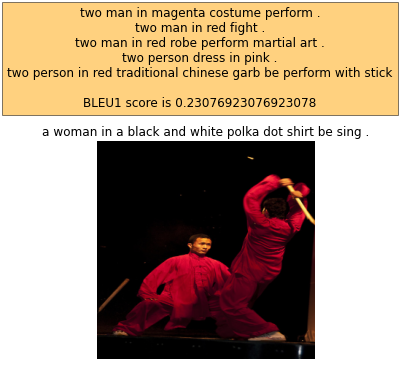

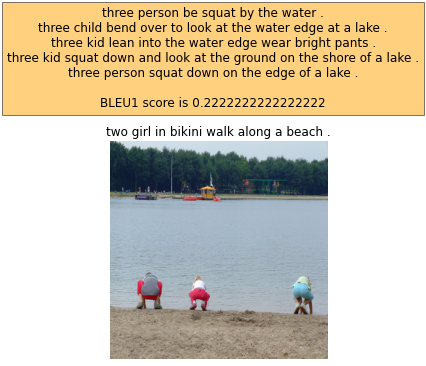

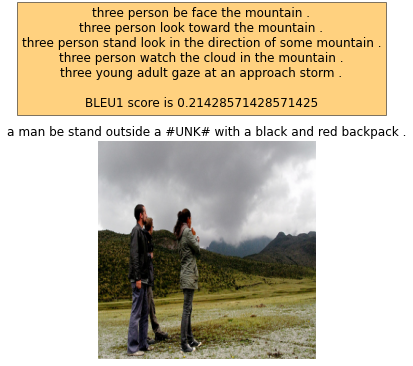

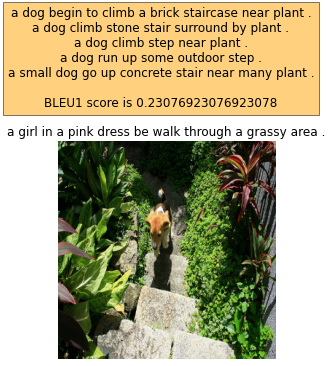

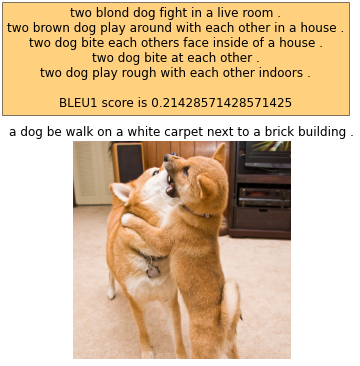

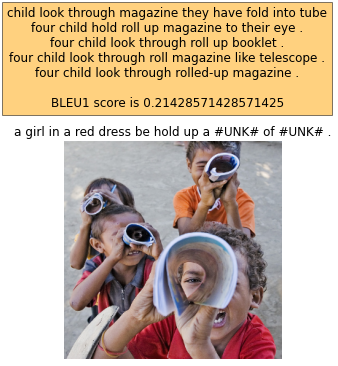

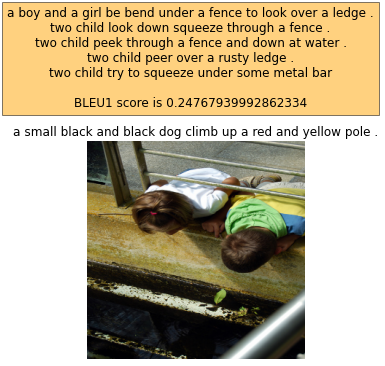

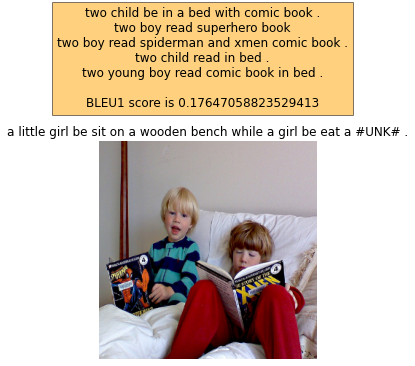

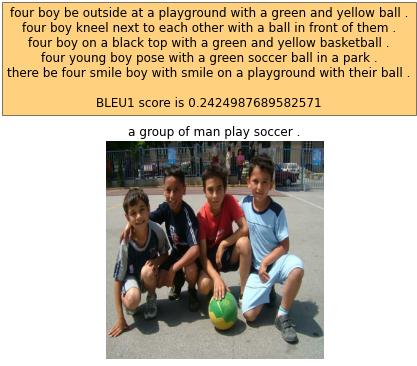

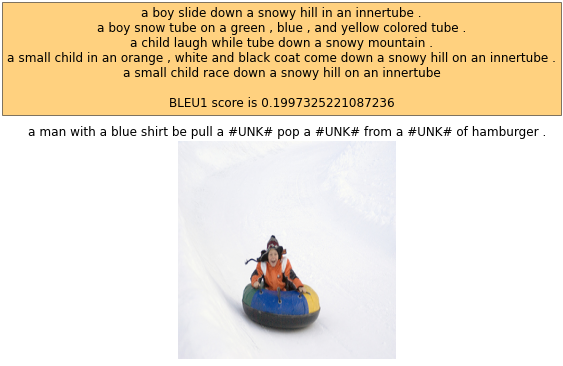

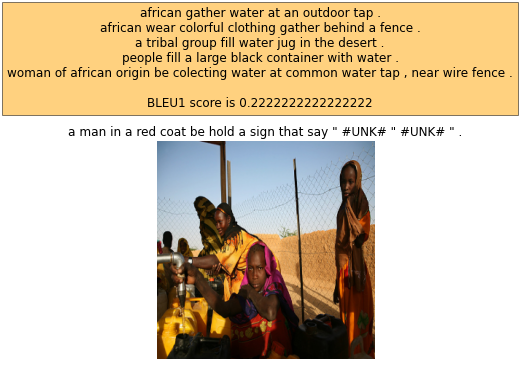

In [66]:
idx = 0

fig=plt.figure(figsize=(8, 8))

for path in dev_image_names():
    bleu1score = bleu1[idx]
    idx += 1
    #print(bleu1score)
    if bleu1score >= bleu1_threshold:
         continue
    
    img = plt.imread(path)
    img = resize(img, (299, 299))
    
    pic_name = path.split('/')[-1].split('.')[0]
    ref_captions = dev_captions[pic_name]
    ref_captions = [item[1:-1] for item in ref_captions] #drop #START and #END
    caption = generate_caption(network, img, t=5., non_random=True)
    
    text = "\n".join([' '.join(words) for words in ref_captions]) + '\n\nBLEU1 score is ' + str(bleu1score)
    
    plt.figure()
    fig = plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.figtext(0.5, 1, text, ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

Best captions by BLEU-4 score

In [71]:
bleu4_threshold = 0.7
print(sum(bleu4 > bleu4_threshold))

10


<Figure size 576x576 with 0 Axes>

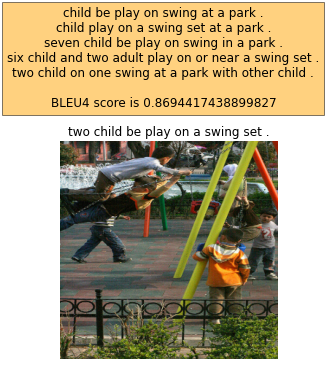

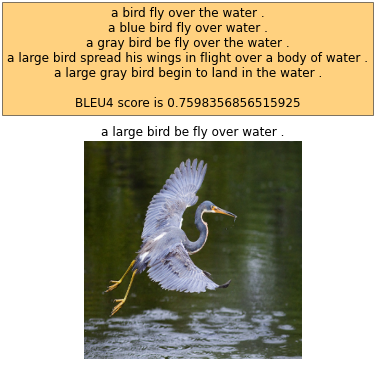

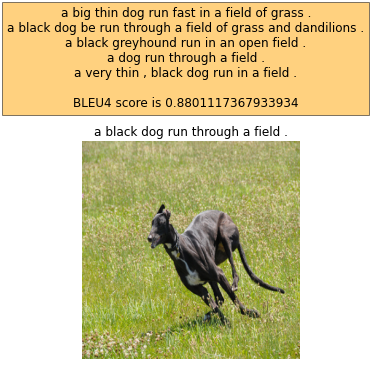

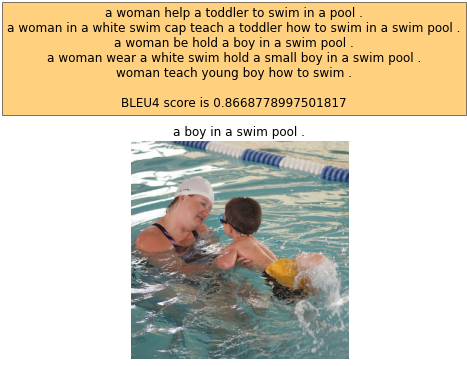

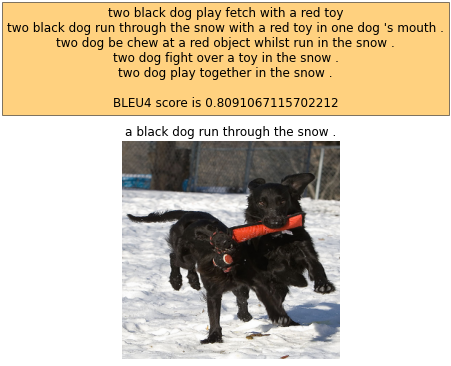

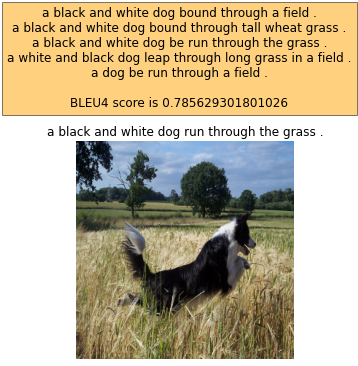

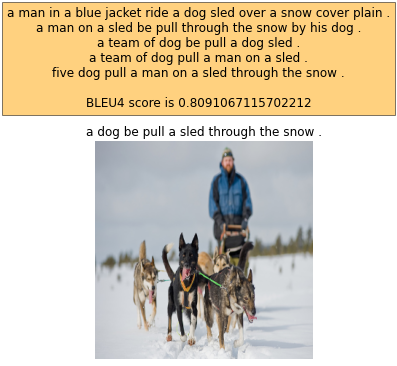

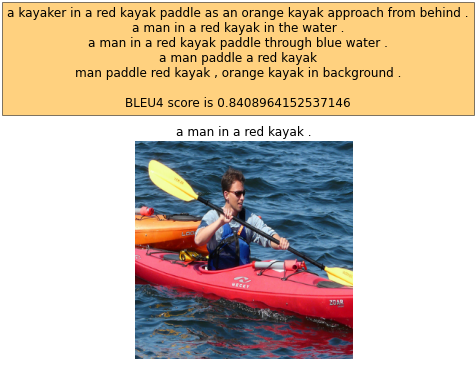

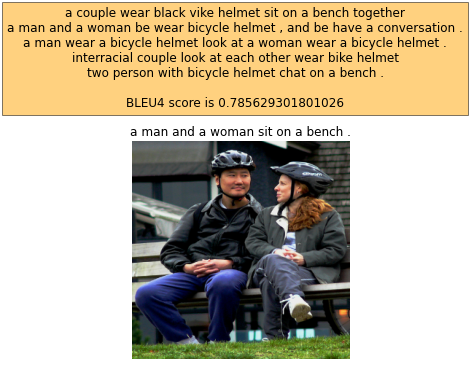

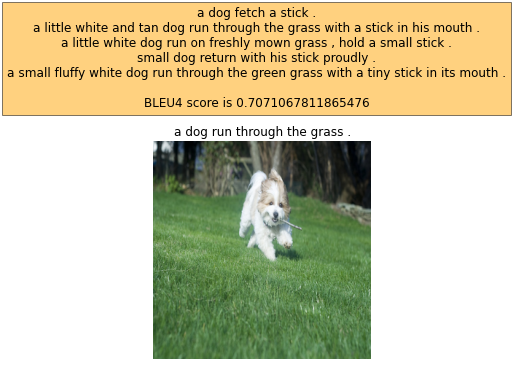

In [73]:
idx = 0

fig=plt.figure(figsize=(8, 8))

for path in dev_image_names():
    bleu4score = bleu4[idx]
    idx += 1
    #print(bleu1score)
    if bleu4score < bleu4_threshold:
         continue
    
    img = plt.imread(path)
    img = resize(img, (299, 299))
    
    pic_name = path.split('/')[-1].split('.')[0]
    ref_captions = dev_captions[pic_name]
    ref_captions = [item[1:-1] for item in ref_captions] #drop #START and #END
    caption = generate_caption(network, img, t=5., non_random=True)
    
    text = "\n".join([' '.join(words) for words in ref_captions]) + '\n\nBLEU4 score is ' + str(bleu4score)
    
    plt.figure()
    fig = plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.figtext(0.5, 1, text, ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})